In [1]:
import pandas as pd
import numpy as np
import xlwt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import label_binarize,StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LassoCV
from keras.models import Sequential
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc,precision_recall_curve,f1_score,confusion_matrix, ConfusionMatrixDisplay,matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
import shap
import numpy as np
from scipy import interp
import xlwt
import matplotlib.pyplot as plt
import joblib
from itertools import cycle
import plotly.express as px

In [2]:
df = pd.read_excel('df.xlsx')

In [3]:
data1 = df.drop(columns=['住院号','免疫抑制剂','免疫抑制剂分类','PHQ-9抑郁','6月后随访PHQ-9','是否抗抑郁治疗','GAD-7焦虑',
                       '6月后随访GAD-7','是否抗焦虑治疗','是否使用生物制剂','精神用药','第一诊断'],axis=1)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 46 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   疲劳         480 non-null    int64  
 1   感染         480 non-null    int64  
 2   疼痛评分       480 non-null    int64  
 3   DAS28-CRP  380 non-null    float64
 4   纤维肌痛       480 non-null    int64  
 5   泼尼松        458 non-null    float64
 6   生物制剂       480 non-null    int64  
 7   经典免疫制剂     480 non-null    int64  
 8   传统抗风湿药     480 non-null    int64  
 9   抑郁         480 non-null    int64  
 10  性别         480 non-null    int64  
 11  年龄         480 non-null    int64  
 12  婚姻         480 non-null    int64  
 13  病史         480 non-null    float64
 14  教育         480 non-null    float64
 15  睡眠时间       479 non-null    float64
 16  其他免疫病      480 non-null    int64  
 17  甲状腺疾病      480 non-null    int64  
 18  糖尿病        480 non-null    int64  
 19  其他慢性病      477 non-null    float64
 20  T-SPOT    

In [4]:
##缺失值超过20%的样本需删除
data2 = data1.dropna(thresh=9)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 479
Data columns (total 46 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   疲劳         480 non-null    int64  
 1   感染         480 non-null    int64  
 2   疼痛评分       480 non-null    int64  
 3   DAS28-CRP  380 non-null    float64
 4   纤维肌痛       480 non-null    int64  
 5   泼尼松        458 non-null    float64
 6   生物制剂       480 non-null    int64  
 7   经典免疫制剂     480 non-null    int64  
 8   传统抗风湿药     480 non-null    int64  
 9   抑郁         480 non-null    int64  
 10  性别         480 non-null    int64  
 11  年龄         480 non-null    int64  
 12  婚姻         480 non-null    int64  
 13  病史         480 non-null    float64
 14  教育         480 non-null    float64
 15  睡眠时间       479 non-null    float64
 16  其他免疫病      480 non-null    int64  
 17  甲状腺疾病      480 non-null    int64  
 18  糖尿病        480 non-null    int64  
 19  其他慢性病      477 non-null    float64
 20  T-SPOT    

In [5]:
##删除缺失值超过25%
missing_values_count = data2.isnull().sum()
missing_values_ratio = missing_values_count / data2.shape[0]
remove_columns = missing_values_ratio[missing_values_ratio >= 0.25].index.tolist()
data = data2.drop(columns=remove_columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 479
Data columns (total 40 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   疲劳         480 non-null    int64  
 1   感染         480 non-null    int64  
 2   疼痛评分       480 non-null    int64  
 3   DAS28-CRP  380 non-null    float64
 4   纤维肌痛       480 non-null    int64  
 5   泼尼松        458 non-null    float64
 6   生物制剂       480 non-null    int64  
 7   经典免疫制剂     480 non-null    int64  
 8   传统抗风湿药     480 non-null    int64  
 9   抑郁         480 non-null    int64  
 10  性别         480 non-null    int64  
 11  年龄         480 non-null    int64  
 12  婚姻         480 non-null    int64  
 13  病史         480 non-null    float64
 14  教育         480 non-null    float64
 15  睡眠时间       479 non-null    float64
 16  其他免疫病      480 non-null    int64  
 17  甲状腺疾病      480 non-null    int64  
 18  糖尿病        480 non-null    int64  
 19  其他慢性病      477 non-null    float64
 20  白细胞计数     

In [6]:
missing_values_ratio

疲劳           0.000000
感染           0.000000
疼痛评分         0.000000
DAS28-CRP    0.208333
纤维肌痛         0.000000
泼尼松          0.045833
生物制剂         0.000000
经典免疫制剂       0.000000
传统抗风湿药       0.000000
抑郁           0.000000
性别           0.000000
年龄           0.000000
婚姻           0.000000
病史           0.000000
教育           0.000000
睡眠时间         0.002083
其他免疫病        0.000000
甲状腺疾病        0.000000
糖尿病          0.000000
其他慢性病        0.006250
T-SPOT       0.493750
白细胞计数        0.010417
血红蛋白         0.010417
血小板          0.010417
N计数          0.010417
L计数          0.010417
抗RO52抗体      0.000000
APS          0.008333
Rib-P        0.000000
SSA          0.000000
SSB          0.000000
RNP/SM       0.000000
CENP-B       0.000000
IL2          0.295833
IL10         0.295833
IL4          0.295833
TNF          0.295833
IFNr         0.293750
IL6          0.239583
血沉           0.089583
CRP          0.029167
补体C3         0.020833
补体C4         0.022917
IgG          0.031250
ILD          0.002083
PAH       

In [8]:
data.columns

Index(['疲劳', '感染', '疼痛评分', 'DAS28-CRP', '纤维肌痛', '泼尼松', '生物制剂', '经典免疫制剂',
       '传统抗风湿药', '抑郁', '性别', '年龄', '婚姻', '病史', '教育', '睡眠时间', '其他免疫病', '甲状腺疾病',
       '糖尿病', '其他慢性病', '白细胞计数', '血红蛋白', '血小板', 'N计数', 'L计数', '抗RO52抗体', 'APS',
       'Rib-P', 'SSA', 'SSB', 'RNP/SM', 'CENP-B', 'IL6', '血沉', 'CRP', '补体C3',
       '补体C4', 'IgG', 'ILD', 'PAH'],
      dtype='object')

In [9]:
data

,疲劳,感染,疼痛评分,DAS28-CRP,纤维肌痛,泼尼松,生物制剂,经典免疫制剂,传统抗风湿药,抑郁,...,RNP/SM,CENP-B,IL6,血沉,CRP,补体C3,补体C4,IgG,ILD,PAH
0,0,0,0,0.00,0,10.0,0,1,1,0,...,1,0,2.96,NaN,5.88,0.85,0.24,7.25,1.0,1
1,2,1,0,0.00,0,40.0,0,0,1,2,...,0,1,2.45,20.0,3.45,0.74,0.19,12.10,1.0,1
2,2,0,0,0.00,1,40.0,1,0,0,2,...,0,0,1.33,50.0,1.98,0.74,0.12,11.20,1.0,0
3,1,1,1,NaN,0,50.0,0,0,1,2,...,1,0,4.27,85.0,18.30,0.43,0.10,29.30,1.0,0
4,2,1,2,NaN,0,50.0,0,0,1,0,...,1,0,6.82,137.0,2.77,0.92,0.08,29.80,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1,0,5,4.47,0,5.0,0,0,1,1,...,0,0,NaN,55.0,9.01,0.97,0.36,13.40,0.0,0
476,0,0,0,0.00,0,45.0,0,0,1,0,...,0,0,NaN,8.0,2.30,0.46,0.03,11.50,0.0,0
477,3,0,0,0.00,1,40.0,0,0,1,2,...,0,1,NaN,NaN,1.82,0.62,0.20,11.70,0.0,0
478,1,0,0,0.00,0,10.0,0,1,0,1,...,0,0,7.96,71.0,3.48,0.51,0.08,19.60,0.0,0


In [2]:
##导入SLEDAI-2000数据
df_sledai = pd.read_excel('D:\Jupyter_project\结缔组织抑郁\中重度合并后\SLEDAI-2K.xlsx')
df_sledai

,SLEDAI,SLEDAS,PHQ-9 Dep,Grade
0,21,25.81,10,2
1,4,2.08,5,1
2,4,2.08,0,0
3,12,19.15,2,0
4,2,1.12,11,2
...,...,...,...,...
80,4,3.95,5,1
81,8,10.81,0,0
82,6,15.86,7,1
83,4,2.08,0,0


In [4]:
df_y = df_sledai['Grade'].copy()
df_x = df_sledai[['SLEDAI','SLEDAS']].copy()

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(df_x, df_y, test_size=0.2, random_state=2)

In [7]:
train_sle = pd.concat([xtrain, ytrain],axis=1)
test_sle = pd.concat([xtest, ytest],axis=1)

In [9]:
train_sle.to_excel('train_sle.xlsx',index=False)
test_sle.to_excel('test_sle.xlsx',index=False)

In [9]:
y = data['抑郁'].copy()
x = data.drop(columns=['抑郁'],axis=1)

In [10]:
#trainx1, valx, trainy1, valy = train_test_split(x, y, test_size= 0.2, random_state = 2)
trainx, testx, trainy, testy = train_test_split(x, y , test_size= 0.2, random_state = 2)

In [11]:
train = pd.concat([trainx, trainy], axis=1)
test = pd.concat([testx, testy], axis=1)

In [12]:
#train.to_excel('train.xlsx',index=False)
#test.to_excel('test.xlsx',index=False)

In [8]:
train = pd.read_excel('train.xlsx')
test = pd.read_excel('test.xlsx')

In [9]:
test.isnull().sum()

疲劳           0
感染           0
疼痛评分         0
DAS28CRP    21
纤维肌痛         0
泼尼松          2
生物制剂         0
经典免疫制剂       0
传统抗风湿药       0
性别           0
年龄           0
婚姻           0
病史           0
教育           0
睡眠时间         0
其他免疫病        0
甲状腺疾病        0
糖尿病          0
其他慢性病        1
白细胞计数        1
血红蛋白         1
血小板          1
N计数          1
L计数          1
抗RO52抗体      0
APS          2
Rib-P        0
SSA          0
SSB          0
RNP/SM       0
CENP-B       0
IL6         20
血沉           7
CRP          3
补体C3         2
补体C4         2
IgG          3
ILD          0
PAH          0
抑郁           0
dtype: int64

In [10]:
##待插补缺失值的变量
categorical_columns_train = train[['其他慢性病','APS','ILD']].copy()
categorical_columns_test = test[['其他慢性病','APS']].copy()

continuous_columns_train = train[['DAS28CRP','泼尼松','睡眠时间','白细胞计数','血红蛋白','血小板','N计数','L计数','IL6','血沉','CRP',
                                 '补体C3','补体C4','IgG']].copy()
continuous_columns_test = test[['DAS28CRP','泼尼松','白细胞计数','血红蛋白','血小板','N计数','L计数','IL6','血沉','CRP','补体C3','补体C4','IgG']].copy()


In [11]:
##训练集
##分类变量众数插补
for col in categorical_columns_train:
    mode_value = train[col].mode()[0]
    train[col].fillna(mode_value, inplace=True)

In [12]:
for col in categorical_columns_test:
    mode_value = test[col].mode()[0]
    test[col].fillna(mode_value, inplace=True)

In [13]:
##连续变量KNN插补
imputer = KNNImputer(n_neighbors=3)
imputed_train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
imputed_test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)

In [14]:
imputed_train.isnull().sum()

疲劳          0
感染          0
疼痛评分        0
DAS28CRP    0
纤维肌痛        0
泼尼松         0
生物制剂        0
经典免疫制剂      0
传统抗风湿药      0
性别          0
年龄          0
婚姻          0
病史          0
教育          0
睡眠时间        0
其他免疫病       0
甲状腺疾病       0
糖尿病         0
其他慢性病       0
白细胞计数       0
血红蛋白        0
血小板         0
N计数         0
L计数         0
抗RO52抗体     0
APS         0
RibP        0
SSA         0
SSB         0
RNPSM       0
CENPB       0
IL6         0
血沉          0
CRP         0
补体C3        0
补体C4        0
IgG         0
ILD         0
PAH         0
抑郁          0
dtype: int64

In [15]:
trainx = imputed_train[['感染','纤维肌痛','经典免疫制剂','其他免疫病','抗RO52抗体','ILD','PAH','疲劳','睡眠时间','血小板','L计数']].copy()
trainy = imputed_train['抑郁'].copy()

testx = imputed_test[['感染','纤维肌痛','经典免疫制剂','其他免疫病','抗RO52抗体','ILD','PAH','疲劳','睡眠时间','血小板','L计数']].copy()
testy = imputed_test['抑郁'].copy()

In [16]:
trainx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   感染       384 non-null    float64
 1   纤维肌痛     384 non-null    float64
 2   经典免疫制剂   384 non-null    float64
 3   其他免疫病    384 non-null    float64
 4   抗RO52抗体  384 non-null    float64
 5   ILD      384 non-null    float64
 6   PAH      384 non-null    float64
 7   疲劳       384 non-null    float64
 8   睡眠时间     384 non-null    float64
 9   血小板      384 non-null    float64
 10  L计数      384 non-null    float64
dtypes: float64(11)
memory usage: 33.1 KB


In [17]:
##归一化
continuous_cols = [7,8, 9, 10]
trainx_standard = trainx.copy()
scaler = StandardScaler()
trainx_standard.iloc[:, continuous_cols] = scaler.fit_transform(trainx_standard.iloc[:, continuous_cols])
trainx_standard

testx_standard = testx.copy()
testx_standard.iloc[:, continuous_cols] = scaler.fit_transform(testx_standard.iloc[:, continuous_cols])

In [18]:
##标签二值化
trainy_bi = label_binarize(trainy, classes=[0, 1, 2])
testy_bi = label_binarize(testy, classes=[0, 1, 2])

In [19]:
clf = LassoCV(alphas=[0.03]).fit(trainx_standard, trainy)
importance = clf.coef_

In [20]:
m = np.flatnonzero(importance).tolist()
m

[4, 7, 8, 9, 10]

In [21]:
importance

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.1125145 ,
        0.        ,  0.        ,  0.41155304, -0.14262946, -0.01249149,
       -0.00066062])

In [22]:
trainx_standard_1 = trainx_standard.iloc[:,m]
testx_standard_1 = testx_standard.iloc[:,m]

In [23]:
trainx_standard_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   抗RO52抗体  384 non-null    float64
 1   疲劳       384 non-null    float64
 2   睡眠时间     384 non-null    float64
 3   血小板      384 non-null    float64
 4   L计数      384 non-null    float64
dtypes: float64(5)
memory usage: 15.1 KB


In [27]:
trainx_standard_1.rename(columns={'抗RO52抗体':'Anti-Ro52','疲劳':'Fatigue','睡眠时间':'Sleep duration',
                                 '血小板':'Platelet','L计数':'Lymphocyte count'},inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
testx_standard_1.rename(columns={'抗RO52抗体':'Anti-Ro52','疲劳':'Fatigue','睡眠时间':'Sleep duration',
                                 '血小板':'Platelet','L计数':'Lymphocyte count'},inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
##计算Kappa值（一致性系数）

def kappa(matrix):
    n = np.sum(matrix)
    sum_po = 0
    sum_pe = 0
    for i in range(len(matrix[0])):
        sum_po += matrix[i][i]
        row = np.sum(matrix[i, :])
        col = np.sum(matrix[:, i])
        sum_pe += row * col
    po = sum_po / n
    pe = sum_pe / (n * n)
    # print(po, pe)
    return (po - pe) / (1 - pe)

ANN

In [19]:
# （early stopping）
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=50,
                          verbose=1)

# 构建ANN模型
lr = 0.001
model = Sequential()
model.add(Dense(256, input_dim=trainx_standard_1.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))  # 三分类
# 编译模型
model.compile(loss='sparse_categorical_crossentropy',  optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

In [20]:
##### 训练模型
model.fit(trainx_standard_1, trainy, epochs=280, batch_size=52,verbose=2, validation_data=(testx_standard_1, testy), callbacks=[earlystop])

Epoch 1/280
8/8 - 1s - loss: 1.0611 - accuracy: 0.4766 - val_loss: 0.9213 - val_accuracy: 0.6354 - 1s/epoch - 126ms/step
Epoch 2/280
8/8 - 0s - loss: 0.9289 - accuracy: 0.5807 - val_loss: 0.7717 - val_accuracy: 0.6771 - 53ms/epoch - 7ms/step
Epoch 3/280
8/8 - 0s - loss: 0.8298 - accuracy: 0.6250 - val_loss: 0.6878 - val_accuracy: 0.6771 - 40ms/epoch - 5ms/step
Epoch 4/280
8/8 - 0s - loss: 0.7794 - accuracy: 0.6328 - val_loss: 0.6550 - val_accuracy: 0.6667 - 49ms/epoch - 6ms/step
Epoch 5/280
8/8 - 0s - loss: 0.7556 - accuracy: 0.6432 - val_loss: 0.6471 - val_accuracy: 0.6771 - 66ms/epoch - 8ms/step
Epoch 6/280
8/8 - 0s - loss: 0.7418 - accuracy: 0.6562 - val_loss: 0.6481 - val_accuracy: 0.6875 - 65ms/epoch - 8ms/step
Epoch 7/280
8/8 - 0s - loss: 0.7370 - accuracy: 0.6615 - val_loss: 0.6296 - val_accuracy: 0.7083 - 72ms/epoch - 9ms/step
Epoch 8/280
8/8 - 0s - loss: 0.7460 - accuracy: 0.6562 - val_loss: 0.6457 - val_accuracy: 0.7188 - 66ms/epoch - 8ms/step
Epoch 9/280
8/8 - 0s - loss: 0.7

In [21]:
y_prob_train_ann = model.predict(trainx_standard_1)
y_prob_test_ann = model.predict(testx_standard_1)
predicted_labels_test = np.argmax(y_prob_test_ann, axis=1)  # 获取最大概率对应的类别
predicted_labels_train = np.argmax(y_prob_train_ann, axis=1)

3/3 [==============================] - 0s 2ms/step


In [22]:
##训练集
confusion_ann_mat1 = confusion_matrix(trainy, predicted_labels_train)
print("confusion_mat_train.shape : {}".format(confusion_ann_mat1.shape))
print("confusion_mat_train:\n{}".format(confusion_ann_mat1))

##测试集
print()
confusion_ann_mat2 = confusion_matrix(testy, predicted_labels_test)
print("confusion_mat_test.shape : {}".format(confusion_ann_mat2.shape))
print("confusion_mat_test:\n{}".format(confusion_ann_mat2))

confusion_mat_train.shape : (3, 3)
confusion_mat_train:
[[156  27   2]
 [ 21  84  16]
 [  4  21  53]]

confusion_mat_test.shape : (3, 3)
confusion_mat_test:
[[47 10  0]
 [ 3 15  5]
 [ 2  6  8]]


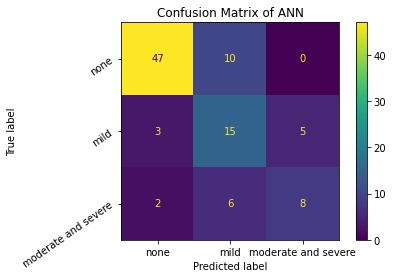

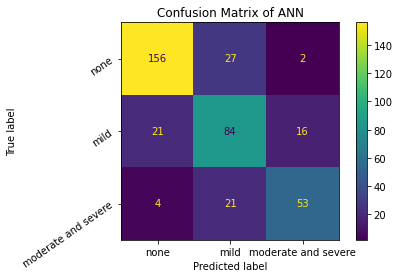

In [38]:
 
#confusion = confusion_matrix(testy,predicted_labels_test)
# 
#fig = px.imshow(confusion, labels=dict(x="Predicted label", y="Actual label"), x=['none','mild','moderate and severe'],y=['none','mild','moderate and severe'],
#                text_auto=True, title='Confusion Matrix of ANN')
#fig.update_layout(title_x=0.5)
##fig.show()
##fig.write_image("confusion_matrix_ann.png", engine="kaleido")


classes = ['none','mild','moderate and severe']
#fig = plt.figure(figsize=(15, 15))
disp1_ann = ConfusionMatrixDisplay(confusion_matrix=confusion_ann_mat2, display_labels=classes)
disp1_ann.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of ANN')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp1_ann.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_ann.tiff',figsize=(10,10),dpi=300)


disp2_ann = ConfusionMatrixDisplay(confusion_matrix=confusion_ann_mat1, display_labels=classes)
disp2_ann.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of ANN')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp2_ann.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_ann_train.tiff',dpi=300)

In [24]:
y_prob_train_ann.shape

(384, 3)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


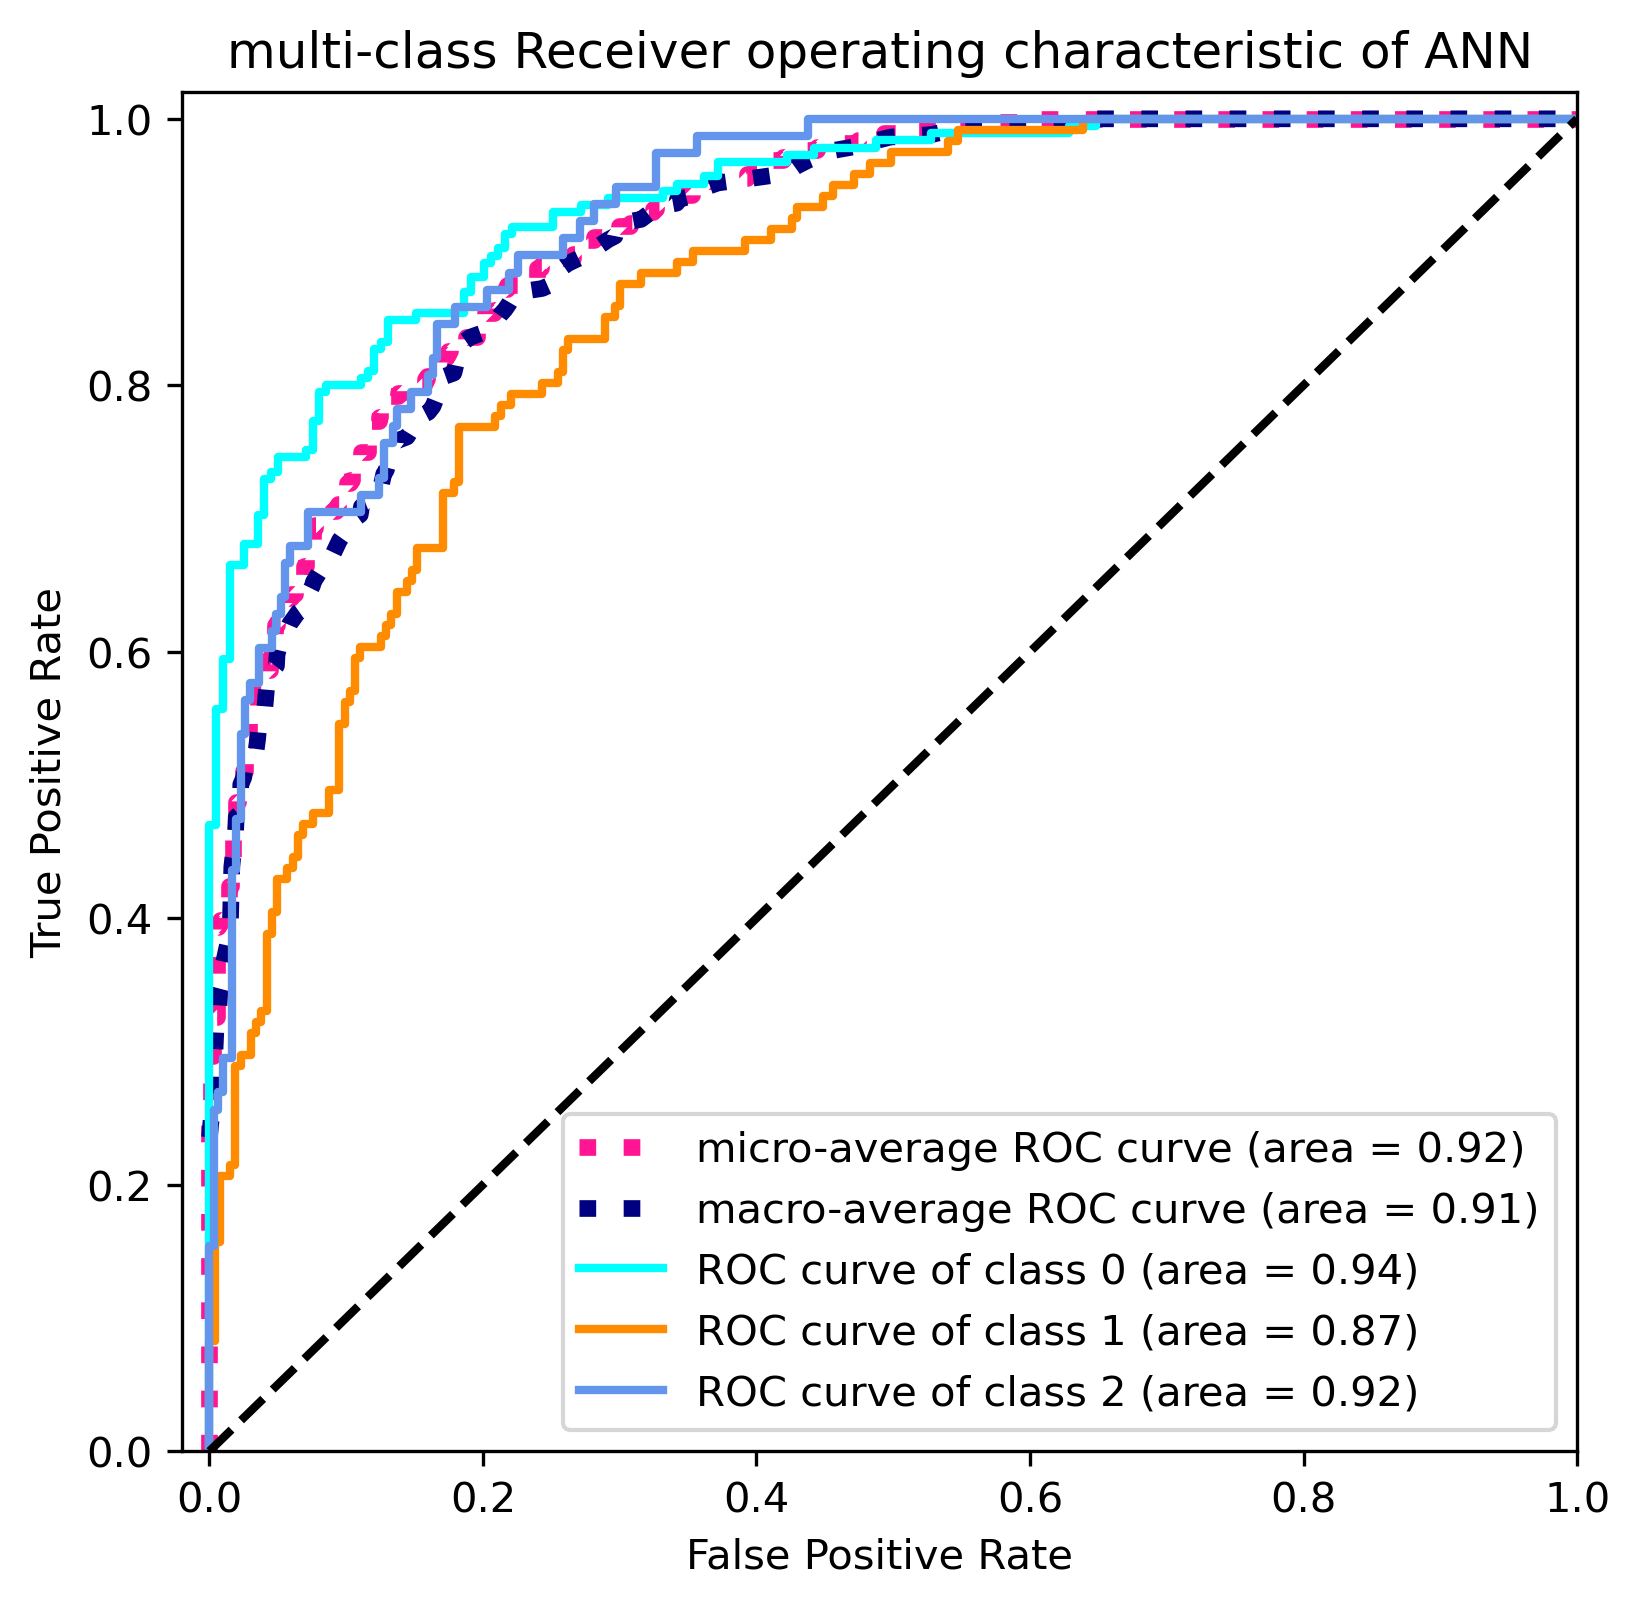

In [34]:
##训练集
# 设置种类
n_classes = trainy_bi.shape[1]
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(trainy_bi[:, i], y_prob_train_ann[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(trainy_bi.ravel(), y_prob_train_ann.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of ANN')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_ann_train.tiff',dpi=300)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


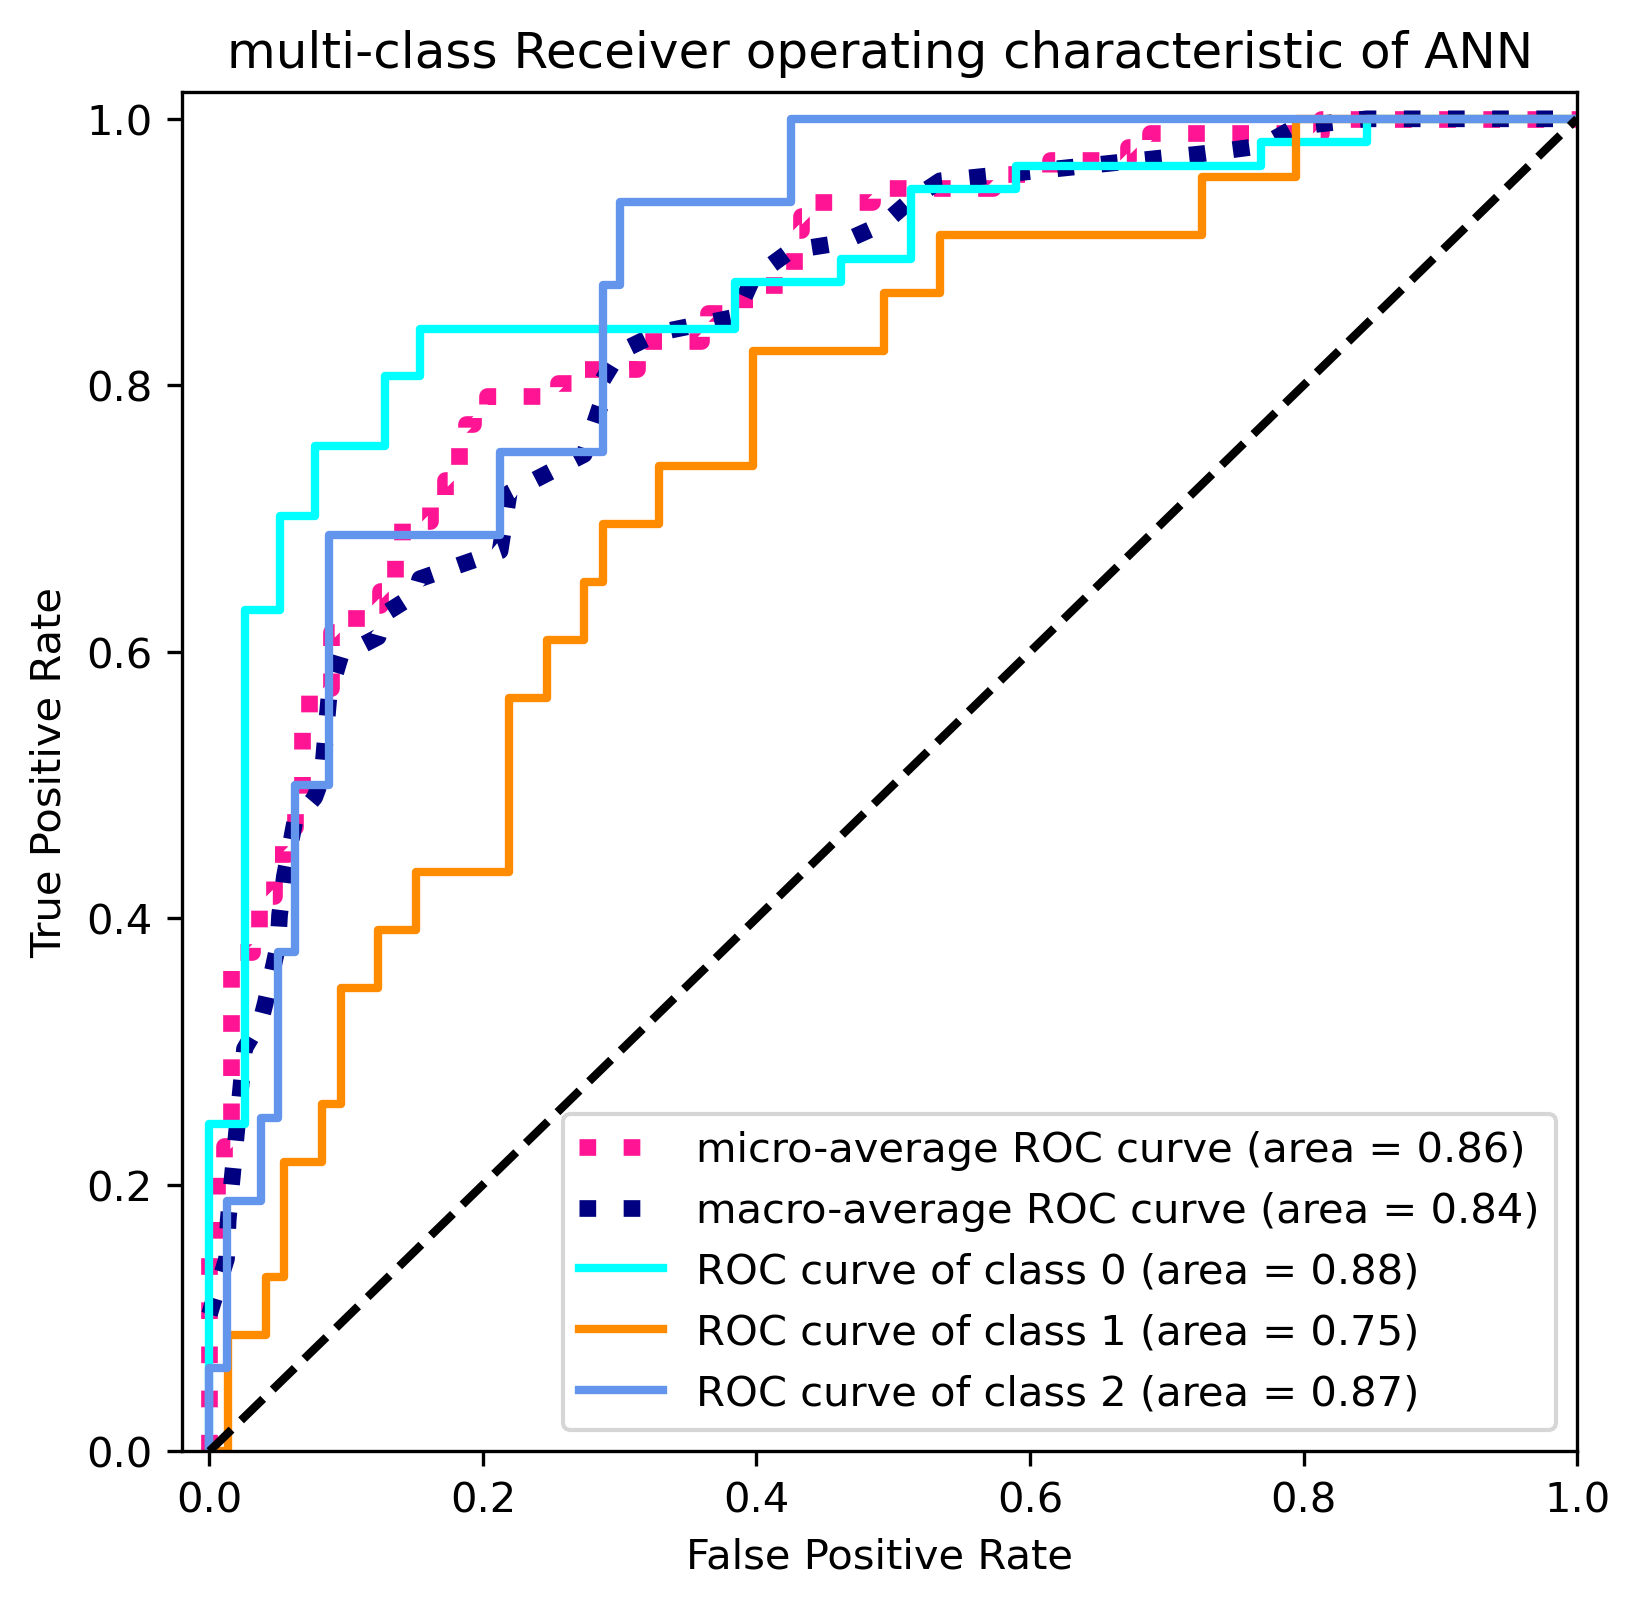

In [33]:
##测试集
# 设置种类
n_classes = trainy_bi.shape[1]
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy_bi[:, i], y_prob_test_ann[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(testy_bi.ravel(), y_prob_test_ann.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of ANN')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_ann_test.tiff',dpi=300)

In [31]:
##训练集
accuracy_train_ann = metrics.accuracy_score(trainy,predicted_labels_train)
print("accuracy_train_ann:{:.3}".format(accuracy_train_ann))
print()

##print("参数为None：输出每一类的指标")
none_p_train_ann = metrics.precision_score(trainy,predicted_labels_train, average=None)
none_r_train_ann = metrics.recall_score(trainy,predicted_labels_train, average=None)
none_f1_train_ann = metrics.f1_score(trainy,predicted_labels_train, average=None)
np.set_printoptions(precision=3) 
print("none_p_train_ann:{}".format(none_p_train_ann))
print("none_r_train_ann:{}".format(none_r_train_ann))
print("none_f1_train_ann:{}".format(none_f1_train_ann))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_train_ann = metrics.precision_score(trainy,predicted_labels_train, average='macro')
macro_r_train_ann = metrics.recall_score(trainy,predicted_labels_train, average='macro')
macro_f1_train_ann = metrics.f1_score(trainy,predicted_labels_train, average='macro')
print("macro_p_train_ann:{:.3}".format(macro_p_train_ann))
print("macro_r_train_ann:{:.3}".format(macro_r_train_ann))
print("macro_f1_train_ann:{:.3}".format(macro_f1_train_ann))
print()

##print("参数为micro")
micro_p_train_ann = metrics.precision_score(trainy,predicted_labels_train, average='micro')
micro_r_train_ann = metrics.recall_score(trainy,predicted_labels_train, average='micro')
micro_f1_train_ann = metrics.f1_score(trainy,predicted_labels_train, average='micro')
print("micro_p_train_ann:{:.3}".format(micro_p_train_ann))
print("micro_r_train_ann:{:.3}".format(micro_r_train_ann))
print("micro_f1_train_ann:{:.3}".format(micro_f1_train_ann))
print()

##print("参数为weighted")
weighted_p_train_ann = metrics.precision_score(trainy,predicted_labels_train, average='weighted')
weighted_r_train_ann = metrics.recall_score(trainy,predicted_labels_train, average='weighted')
weighted_f1_train_ann = metrics.f1_score(trainy,predicted_labels_train, average='weighted')
print("weighted_p_train_ann:{:.3}".format(weighted_p_train_ann))
print("weighted_r_train_ann:{:.3}".format(weighted_r_train_ann))
print("weighted_f1_train_ann:{:.3}".format(weighted_f1_train_ann))
print()

##马修斯相关系数
mcc_ann_train = matthews_corrcoef(trainy, predicted_labels_train)
print("mcc_train_ann:{:.3}".format(mcc_ann_train))
print()

##kappa
matrix1_ann = np.array(confusion_ann_mat1)
matrix2_ann = np.array(confusion_ann_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_train_ann:{:.3}".format(kappa(matrix1_ann)))

accuracy_train_ann:0.763

none_p_train_ann:[0.862 0.636 0.746]
none_r_train_ann:[0.843 0.694 0.679]
none_f1_train_ann:[0.852 0.664 0.711]

macro_p_train_ann:0.748
macro_r_train_ann:0.739
macro_f1_train_ann:0.743

micro_p_train_ann:0.763
micro_r_train_ann:0.763
micro_f1_train_ann:0.763

weighted_p_train_ann:0.767
weighted_r_train_ann:0.763
weighted_f1_train_ann:0.764

mcc_train_ann:0.623

kappa_train_ann:0.622


In [32]:
##测试集
accuracy_test_ann = metrics.accuracy_score(testy,predicted_labels_test)
print("accuracy_test_ann:{:.3}".format(accuracy_test_ann))
print()

##print("参数为None：输出每一类的指标")
none_p_test_ann = metrics.precision_score(testy,predicted_labels_test, average=None)
none_r_test_ann = metrics.recall_score(testy,predicted_labels_test, average=None)
none_f1_test_ann = metrics.f1_score(testy,predicted_labels_test, average=None)
np.set_printoptions(precision=3) 
print("none_p_test_ann:{}".format(none_p_test_ann))
print("none_r_test_ann:{}".format(none_r_test_ann))
print("none_f1_test_ann:{}".format(none_f1_test_ann))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_test_ann = metrics.precision_score(testy,predicted_labels_test, average='macro')
macro_r_test_ann = metrics.recall_score(testy,predicted_labels_test, average='macro')
macro_f1_test_ann = metrics.f1_score(testy,predicted_labels_test, average='macro')
print("macro_p_test_ann:{:.3}".format(macro_p_test_ann))
print("macro_r_test_ann:{:.3}".format(macro_r_test_ann))
print("macro_f1_test_ann:{:.3}".format(macro_f1_test_ann))
print()

##print("参数为micro")
micro_p_test_ann = metrics.precision_score(testy,predicted_labels_test, average='micro')
micro_r_test_ann = metrics.recall_score(testy,predicted_labels_test, average='micro')
micro_f1_test_ann = metrics.f1_score(testy,predicted_labels_test, average='micro')
print("micro_p_test_ann:{:.3}".format(micro_p_test_ann))
print("micro_r_test_ann:{:.3}".format(micro_r_test_ann))
print("micro_f1_test_ann:{:.3}".format(micro_f1_test_ann))
print()

##print("参数为weighted")
weighted_p_test_ann = metrics.precision_score(testy,predicted_labels_test, average='weighted')
weighted_r_test_ann = metrics.recall_score(testy,predicted_labels_test, average='weighted')
weighted_f1_test_ann = metrics.f1_score(testy,predicted_labels_test, average='weighted')
print("weighted_p_test_ann:{:.3}".format(weighted_p_test_ann))
print("weighted_r_test_ann:{:.3}".format(weighted_r_test_ann))
print("weighted_f1_test_ann:{:.3}".format(weighted_f1_test_ann))
print()

##马修斯相关系数
mcc_ann_test = matthews_corrcoef(testy, predicted_labels_test)
print("mcc_test_ann:{:.3}".format(mcc_ann_test))
print()

##kappa
print("kappa_test_ann:{:.3}".format(kappa(matrix2_ann)))

accuracy_test_ann:0.729

none_p_test_ann:[0.904 0.484 0.615]
none_r_test_ann:[0.825 0.652 0.5  ]
none_f1_test_ann:[0.862 0.556 0.552]

macro_p_test_ann:0.668
macro_r_test_ann:0.659
macro_f1_test_ann:0.657

micro_p_test_ann:0.729
micro_r_test_ann:0.729
micro_f1_test_ann:0.729

weighted_p_test_ann:0.755
weighted_r_test_ann:0.729
weighted_f1_test_ann:0.737

mcc_test_ann:0.537

kappa_test_ann:0.532


Catboost

In [49]:
# 定义CatBoost分类器
cat = CatBoostClassifier(iterations=300, learning_rate=0.025, depth=5, loss_function='MultiClass')
cat.fit(trainx_standard_1, trainy)

0:	learn: 1.0878549	total: 152ms	remaining: 45.5s
1:	learn: 1.0766020	total: 155ms	remaining: 23.1s
2:	learn: 1.0657487	total: 158ms	remaining: 15.6s
3:	learn: 1.0568152	total: 159ms	remaining: 11.8s
4:	learn: 1.0456646	total: 162ms	remaining: 9.55s
5:	learn: 1.0369533	total: 165ms	remaining: 8.06s
6:	learn: 1.0275185	total: 167ms	remaining: 7s
7:	learn: 1.0201866	total: 169ms	remaining: 6.17s
8:	learn: 1.0113412	total: 172ms	remaining: 5.56s
9:	learn: 1.0025161	total: 173ms	remaining: 5.03s
10:	learn: 0.9946880	total: 176ms	remaining: 4.62s
11:	learn: 0.9869212	total: 178ms	remaining: 4.28s
12:	learn: 0.9794609	total: 181ms	remaining: 3.98s
13:	learn: 0.9721074	total: 183ms	remaining: 3.73s
14:	learn: 0.9662737	total: 184ms	remaining: 3.5s
15:	learn: 0.9590992	total: 186ms	remaining: 3.3s
16:	learn: 0.9519080	total: 187ms	remaining: 3.12s
17:	learn: 0.9451758	total: 189ms	remaining: 2.96s
18:	learn: 0.9388255	total: 190ms	remaining: 2.81s
19:	learn: 0.9341503	total: 191ms	remaining: 2

206:	learn: 0.6390183	total: 495ms	remaining: 222ms
207:	learn: 0.6387710	total: 496ms	remaining: 219ms
208:	learn: 0.6384731	total: 497ms	remaining: 216ms
209:	learn: 0.6380290	total: 498ms	remaining: 214ms
210:	learn: 0.6372074	total: 499ms	remaining: 211ms
211:	learn: 0.6366843	total: 500ms	remaining: 208ms
212:	learn: 0.6361210	total: 502ms	remaining: 205ms
213:	learn: 0.6357385	total: 503ms	remaining: 202ms
214:	learn: 0.6352372	total: 504ms	remaining: 199ms
215:	learn: 0.6348429	total: 505ms	remaining: 197ms
216:	learn: 0.6345750	total: 507ms	remaining: 194ms
217:	learn: 0.6338084	total: 508ms	remaining: 191ms
218:	learn: 0.6330817	total: 510ms	remaining: 188ms
219:	learn: 0.6325778	total: 512ms	remaining: 186ms
220:	learn: 0.6319372	total: 513ms	remaining: 183ms
221:	learn: 0.6307474	total: 515ms	remaining: 181ms
222:	learn: 0.6301512	total: 517ms	remaining: 179ms
223:	learn: 0.6296628	total: 520ms	remaining: 176ms
224:	learn: 0.6287642	total: 522ms	remaining: 174ms
225:	learn: 

In [78]:
trainx_1 = train[['疲劳','睡眠时间','抗RO52抗体','血小板','L计数']]

In [79]:
#cat.fit(trainx_1,trainy)

In [80]:
# 保存模型
#joblib.dump(cat, 'cat_model.pkl')

In [50]:
y_prob_train_cat = cat.predict_proba(trainx_standard_1)
y_prob_test_cat = cat.predict_proba(testx_standard_1)

y_pred_train_cat = cat.predict(trainx_standard_1)
y_pred_test_cat = cat.predict(testx_standard_1)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


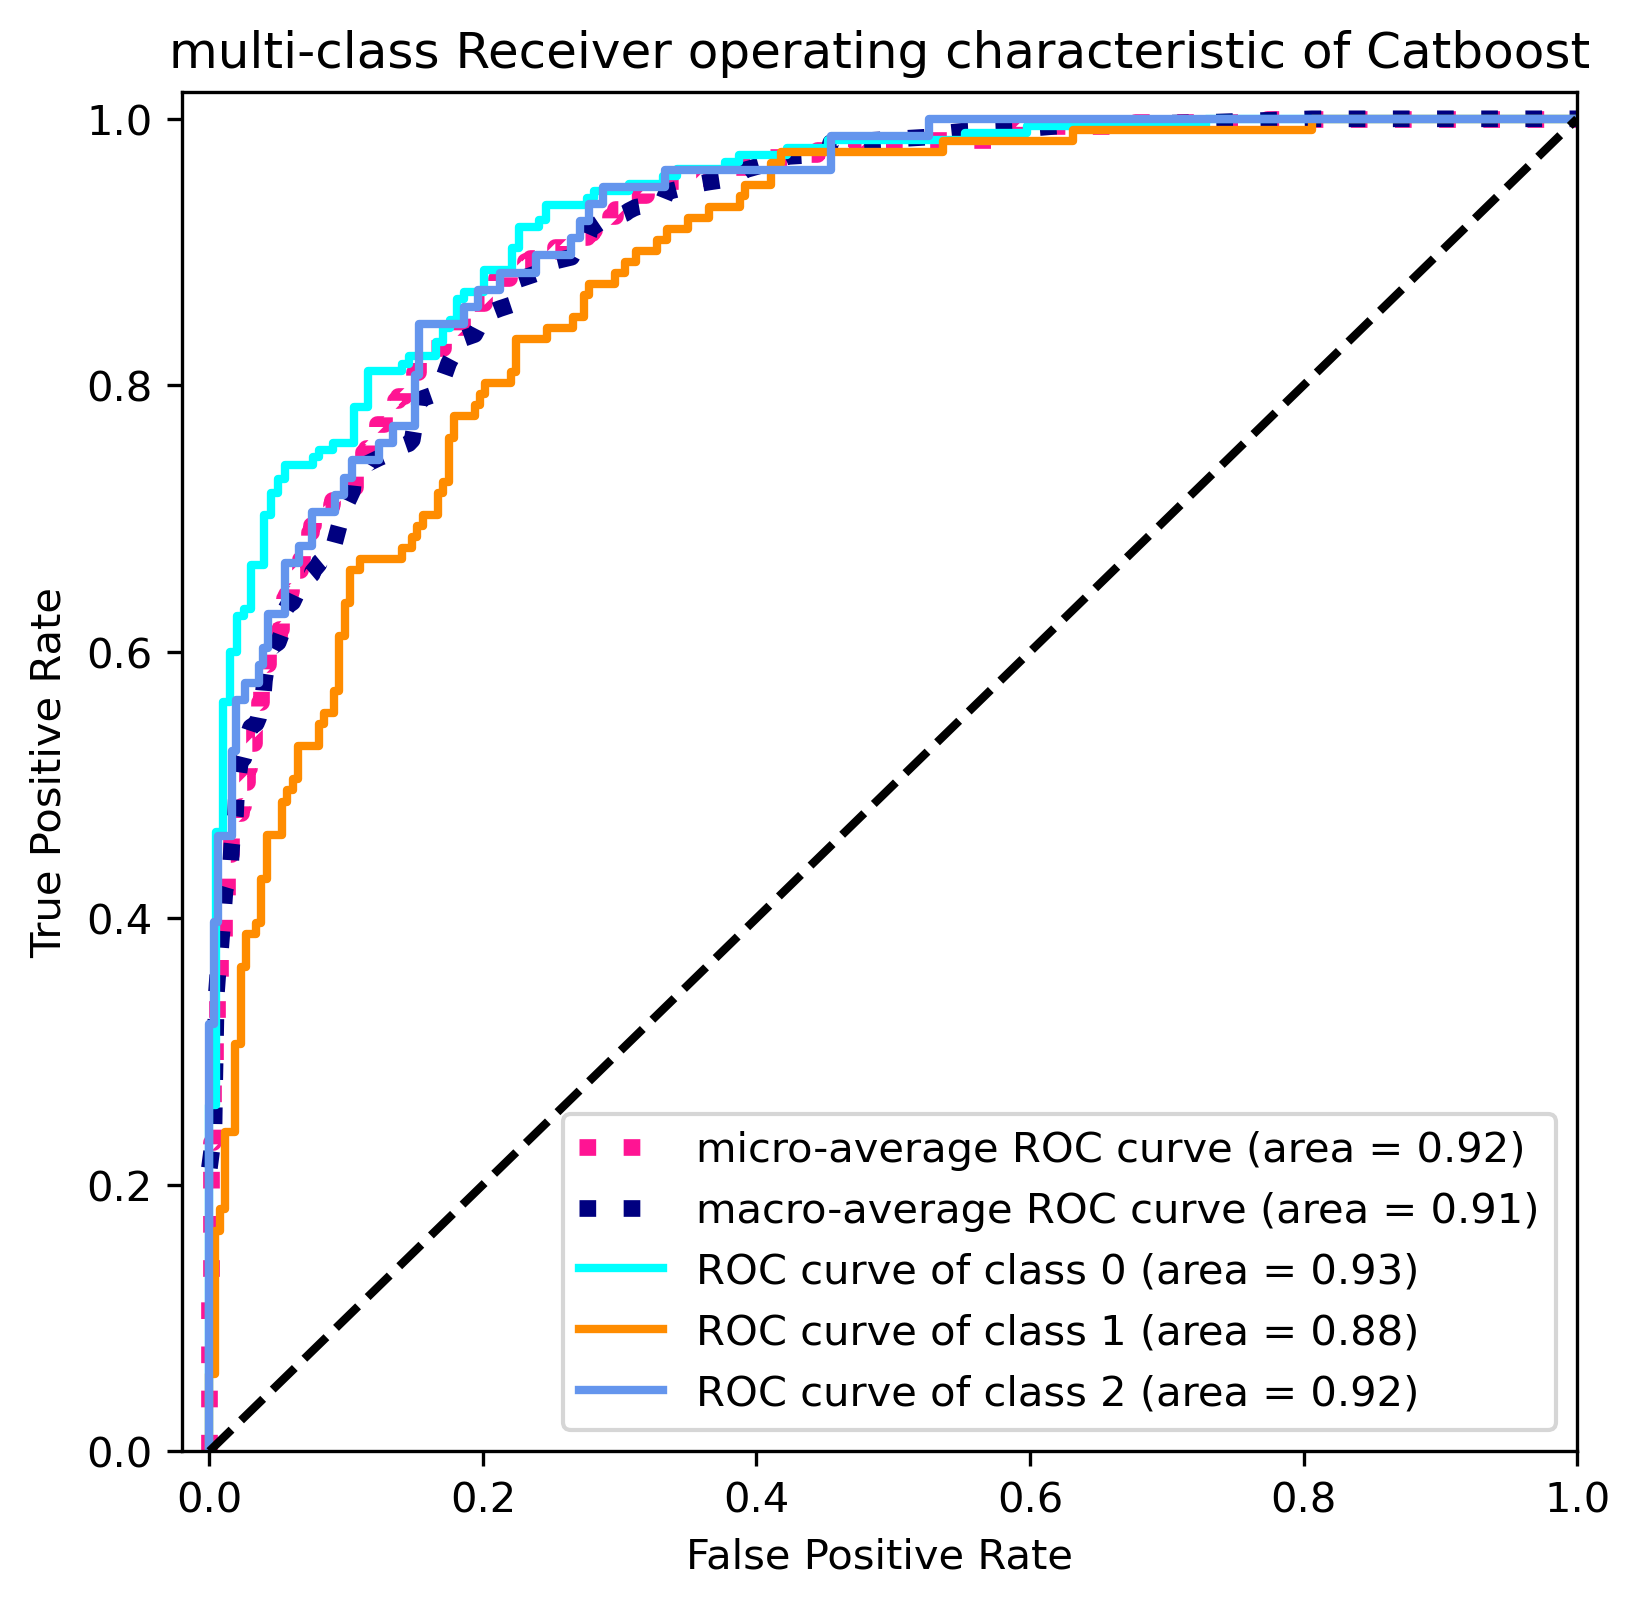

In [51]:
n_classes = trainy_bi.shape[1]
##训练集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(trainy_bi[:, i], y_prob_train_cat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(trainy_bi.ravel(), y_prob_train_cat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of Catboost')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_cat_train.tiff',dpi=300)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


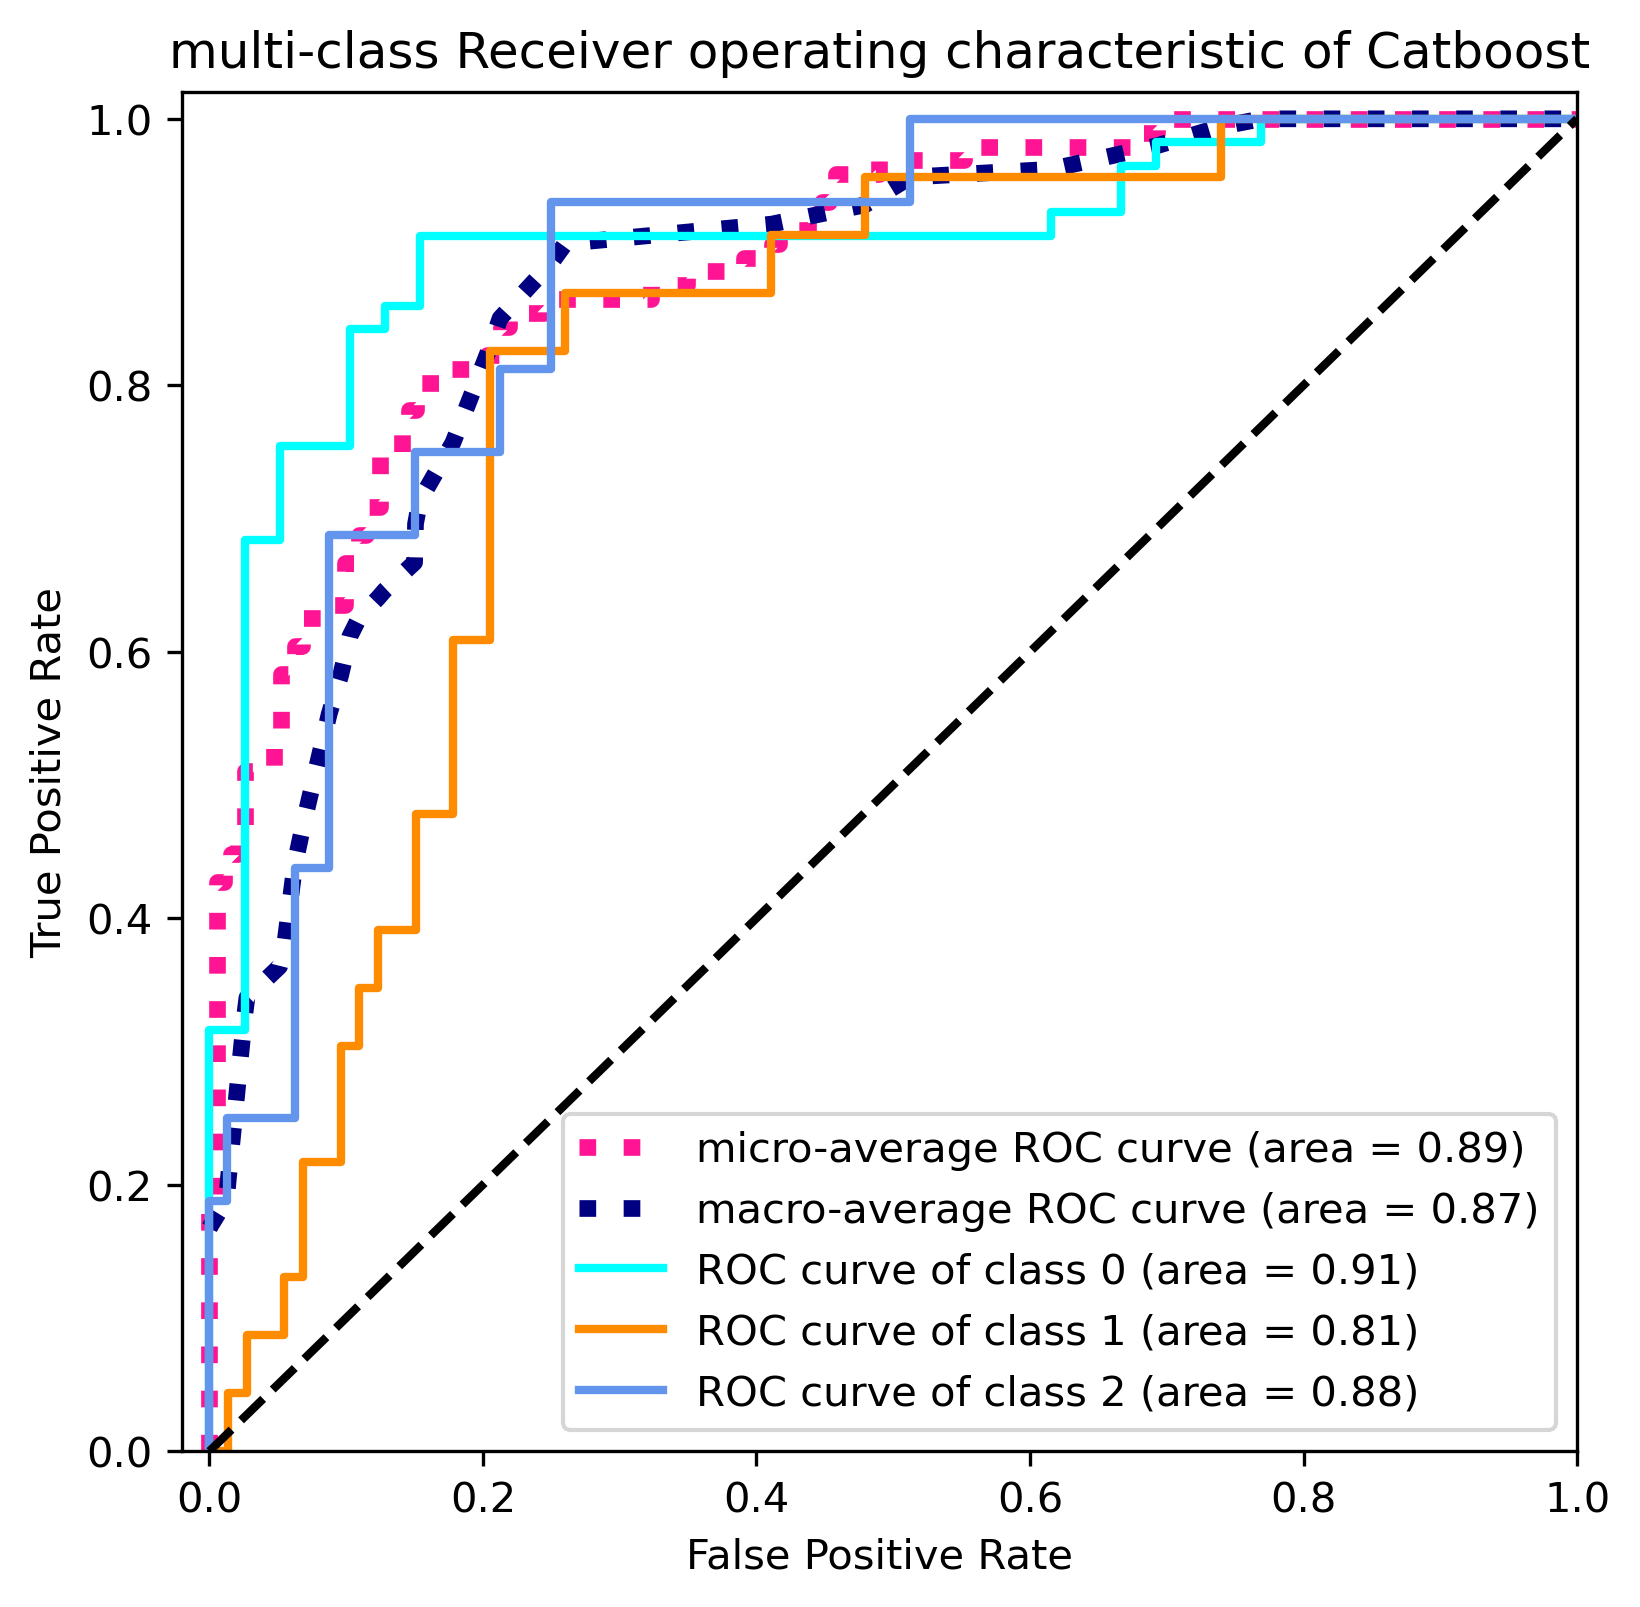

In [52]:
##测试集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy_bi[:, i], y_prob_test_cat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(testy_bi.ravel(), y_prob_test_cat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of Catboost')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_cat_test.tiff',dpi=300)

In [53]:
confusion_cat_mat1 = confusion_matrix(trainy, y_pred_train_cat)
print("confusion_mat_train.shape : {}".format(confusion_cat_mat1.shape))
print("confusion_mat_train:\n{}".format(confusion_cat_mat1))

##测试集
print()
confusion_cat_mat2 = confusion_matrix(testy, y_pred_test_cat)
print("confusion_mat_test.shape : {}".format(confusion_cat_mat2.shape))
print("confusion_mat_test:\n{}".format(confusion_cat_mat2))

confusion_mat_train.shape : (3, 3)
confusion_mat_train:
[[157  26   2]
 [ 26  89   6]
 [  8  24  46]]

confusion_mat_test.shape : (3, 3)
confusion_mat_test:
[[50  7  0]
 [ 4 16  3]
 [ 3  7  6]]


[None, None, None, None, None, None]

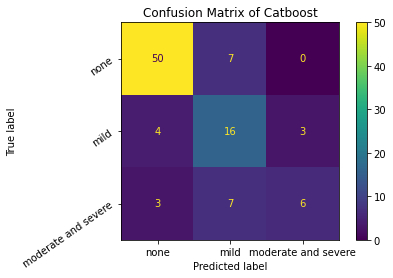

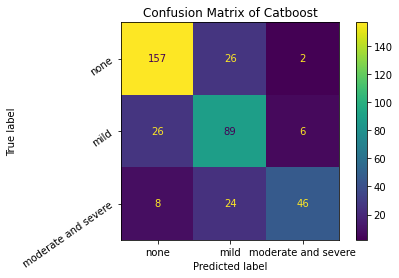

In [54]:
classes = ['none','mild','moderate and severe']
#fig = plt.figure(figsize=(15, 15))
disp2_cat = ConfusionMatrixDisplay(confusion_matrix=confusion_cat_mat2, display_labels=classes)
disp2_cat.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of Catboost')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp2_cat.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_cat_test.tiff',figsize=(10,10),dpi=300)


disp1_cat = ConfusionMatrixDisplay(confusion_matrix=confusion_cat_mat1, display_labels=classes)
disp1_cat.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of Catboost')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp1_cat.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_cat_train.tiff',dpi=300)

In [55]:
##训练集
accuracy_train_cat = metrics.accuracy_score(trainy,y_pred_train_cat)
print("accuracy_train_cat:{:.3}".format(accuracy_train_cat))
print()

##print("参数为None：输出每一类的指标")
none_p_train_cat = metrics.precision_score(trainy,y_pred_train_cat, average=None)
none_r_train_cat = metrics.recall_score(trainy,y_pred_train_cat, average=None)
none_f1_train_cat = metrics.f1_score(trainy,y_pred_train_cat, average=None)
np.set_printoptions(precision=3) 
print("none_p_train_cat:{}".format(none_p_train_cat))
print("none_r_train_cat:{}".format(none_r_train_cat))
print("none_f1_train_cat:{}".format(none_f1_train_cat))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_train_cat = metrics.precision_score(trainy,y_pred_train_cat, average='macro')
macro_r_train_cat = metrics.recall_score(trainy,y_pred_train_cat, average='macro')
macro_f1_train_cat = metrics.f1_score(trainy,y_pred_train_cat, average='macro')
print("macro_p_train_cat:{:.3}".format(macro_p_train_cat))
print("macro_r_train_cat:{:.3}".format(macro_r_train_cat))
print("macro_f1_train_cat:{:.3}".format(macro_f1_train_cat))
print()

##print("参数为micro")
micro_p_train_cat = metrics.precision_score(trainy,y_pred_train_cat, average='micro')
micro_r_train_cat = metrics.recall_score(trainy,y_pred_train_cat, average='micro')
micro_f1_train_cat = metrics.f1_score(trainy,y_pred_train_cat, average='micro')
print("micro_p_train_cat:{:.3}".format(micro_p_train_cat))
print("micro_r_train_cat:{:.3}".format(micro_r_train_cat))
print("micro_f1_train_cat:{:.3}".format(micro_f1_train_cat))
print()

##print("参数为weighted")
weighted_p_train_cat = metrics.precision_score(trainy,y_pred_train_cat, average='weighted')
weighted_r_train_cat = metrics.recall_score(trainy,y_pred_train_cat, average='weighted')
weighted_f1_train_cat = metrics.f1_score(trainy,y_pred_train_cat, average='weighted')
print("weighted_p_train_cat:{:.3}".format(weighted_p_train_cat))
print("weighted_r_train_cat:{:.3}".format(weighted_r_train_cat))
print("weighted_f1_train_cat:{:.3}".format(weighted_f1_train_cat))
print()

##马修斯相关系数
mcc_cat_train = matthews_corrcoef(trainy, y_pred_train_cat)
print("mcc_train_cat:{:.3}".format(mcc_cat_train))
print()

##kappa
matrix1_cat = np.array(confusion_cat_mat1)
matrix2_cat = np.array(confusion_cat_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_train_cat:{:.3}".format(kappa(matrix1_cat)))

accuracy_train_cat:0.76

none_p_train_cat:[0.822 0.64  0.852]
none_r_train_cat:[0.849 0.736 0.59 ]
none_f1_train_cat:[0.835 0.685 0.697]

macro_p_train_cat:0.771
macro_r_train_cat:0.725
macro_f1_train_cat:0.739

micro_p_train_cat:0.76
micro_r_train_cat:0.76
micro_f1_train_cat:0.76

weighted_p_train_cat:0.771
weighted_r_train_cat:0.76
weighted_f1_train_cat:0.76

mcc_train_cat:0.615

kappa_train_cat:0.612


In [56]:
##测试集
accuracy_test_cat = metrics.accuracy_score(testy,y_pred_test_cat)
print("accuracy_test_cat:{:.3}".format(accuracy_test_cat))
print()

##print("参数为None：输出每一类的指标")
none_p_test_cat = metrics.precision_score(testy,y_pred_test_cat, average=None)
none_r_test_cat = metrics.recall_score(testy,y_pred_test_cat, average=None)
none_f1_test_cat = metrics.f1_score(testy,y_pred_test_cat, average=None)
np.set_printoptions(precision=3) 
print("none_p_test_cat:{}".format(none_p_test_cat))
print("none_r_test_cat:{}".format(none_r_test_cat))
print("none_f1_test_cat:{}".format(none_f1_test_cat))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_test_cat = metrics.precision_score(testy,y_pred_test_cat, average='macro')
macro_r_test_cat = metrics.recall_score(testy,y_pred_test_cat, average='macro')
macro_f1_test_cat = metrics.f1_score(testy,y_pred_test_cat, average='macro')
print("macro_p_test_cat:{:.3}".format(macro_p_test_cat))
print("macro_r_test_cat:{:.3}".format(macro_r_test_cat))
print("macro_f1_test_cat:{:.3}".format(macro_f1_test_cat))
print()

##print("参数为micro")
micro_p_test_cat = metrics.precision_score(testy,y_pred_test_cat, average='micro')
micro_r_test_cat = metrics.recall_score(testy,y_pred_test_cat, average='micro')
micro_f1_test_cat = metrics.f1_score(testy,y_pred_test_cat, average='micro')
print("micro_p_test_cat:{:.3}".format(micro_p_test_cat))
print("micro_r_test_cat:{:.3}".format(micro_r_test_cat))
print("micro_f1_test_cat:{:.3}".format(micro_f1_test_cat))
print()

##print("参数为weighted")
weighted_p_test_cat = metrics.precision_score(testy,y_pred_test_cat, average='weighted')
weighted_r_test_cat = metrics.recall_score(testy,y_pred_test_cat, average='weighted')
weighted_f1_test_cat = metrics.f1_score(testy,y_pred_test_cat, average='weighted')
print("weighted_p_test_cat:{:.3}".format(weighted_p_test_cat))
print("weighted_r_test_cat:{:.3}".format(weighted_r_test_cat))
print("weighted_f1_test_cat:{:.3}".format(weighted_f1_test_cat))
print()

##马修斯相关系数
mcc_cat_test = matthews_corrcoef(testy, y_pred_test_cat)
print("mcc_test_cat:{:.3}".format(mcc_cat_test))
print()

##kappa
matrix1_cat = np.array(confusion_cat_mat1)
matrix2_cat = np.array(confusion_cat_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_test_cat:{:.3}".format(kappa(matrix2_cat)))

accuracy_test_cat:0.75

none_p_test_cat:[0.877 0.533 0.667]
none_r_test_cat:[0.877 0.696 0.375]
none_f1_test_cat:[0.877 0.604 0.48 ]

macro_p_test_cat:0.692
macro_r_test_cat:0.649
macro_f1_test_cat:0.654

micro_p_test_cat:0.75
micro_r_test_cat:0.75
micro_f1_test_cat:0.75

weighted_p_test_cat:0.76
weighted_r_test_cat:0.75
weighted_f1_test_cat:0.745

mcc_test_cat:0.557

kappa_test_cat:0.551


In [57]:
trainx_standard_1

,Anti-Ro52,Fatigue,Sleep duration,Platelet,Lymphocyte count
0,0.0,2.083805,-0.653836,-0.224995,0.602375
1,1.0,-0.047170,-0.013616,1.814468,-1.232429
2,1.0,-0.047170,1.266825,0.018523,3.181020
3,0.0,2.083805,-1.294057,1.408605,-1.810971
4,0.0,-0.047170,0.626605,2.291357,0.387488
...,...,...,...,...,...
379,1.0,1.018318,-0.653836,0.728784,-0.191054
380,1.0,2.083805,0.626605,0.018523,-0.686947
381,0.0,-1.112658,-0.013616,-0.326461,2.866954
382,1.0,-0.047170,-1.294057,-1.097601,-1.034072


In [152]:
## (1) For each class
#precision = dict()
#recall = dict()
#average_precision = dict()
#
#for i in range(n_classes):
#    precision[i], recall[i], _ = precision_recall_curve(testy_bi[:, i],
#                                                        y_prob_test_cat[:, i])
#
#    average_precision[i] = average_precision_score(testy_bi[:, i], 
#                                                   y_prob_test_cat[:, i])
#
#    print('Average precision score for class {0}: {1:0.2f}'.format(i, average_precision[i]))
#
## (2) A "macro-average": quantifying score on all classes jointly
#precision["macro"], recall["macro"], _ = precision_recall_curve(testy_bi.ravel(),
#                                                                y_prob_test_cat.ravel())
#
#average_precision["macro"] = average_precision_score(testy_bi, y_prob_test_cat,
#                                                     average="macro")
#
#print('Average precision score, macro-averaged over all classes: {0:0.2f}'.format(average_precision["macro"]))

In [153]:
#plt.figure(dpi=300)
#plt.step(recall['macro'], precision['macro'], where='post')
#
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
#plt.title('Average precision score, macro-averaged over all classes: AP={0:0.3f}'.format(average_precision["macro"]))

In [58]:
print(metrics.classification_report(testy,y_pred_test_cat, digits=3))

              precision    recall  f1-score   support

         0.0      0.877     0.877     0.877        57
         1.0      0.533     0.696     0.604        23
         2.0      0.667     0.375     0.480        16

    accuracy                          0.750        96
   macro avg      0.692     0.649     0.654        96
weighted avg      0.760     0.750     0.745        96



In [59]:
def class2(score):
    if score >= 1:
        return 1
    else:
        return 0

df_train = imputed_train.copy()
df_test = imputed_test.copy()
df_train['抑郁'] = df_train['抑郁'].apply(class2)
df_test['抑郁'] = df_test['抑郁'].apply(class2)

In [60]:
df_test['抑郁'].value_counts()

0    57
1    39
Name: 抑郁, dtype: int64

In [61]:
trainy2 = df_train['抑郁'].copy()
testy2 = df_test['抑郁'].copy()

In [62]:
##建立新的二元分类器
cat2 = CatBoostClassifier(iterations=300, learning_rate=0.025, depth=5)
cat2.fit(trainx_standard_1,trainy2)

0:	learn: 0.6762311	total: 2.74ms	remaining: 818ms
1:	learn: 0.6638915	total: 4.06ms	remaining: 605ms
2:	learn: 0.6533040	total: 5.64ms	remaining: 558ms
3:	learn: 0.6422094	total: 7.03ms	remaining: 520ms
4:	learn: 0.6324494	total: 8.36ms	remaining: 493ms
5:	learn: 0.6230528	total: 9.72ms	remaining: 476ms
6:	learn: 0.6123134	total: 11ms	remaining: 461ms
7:	learn: 0.6023184	total: 12.4ms	remaining: 452ms
8:	learn: 0.5906148	total: 13.7ms	remaining: 444ms
9:	learn: 0.5811447	total: 15.2ms	remaining: 440ms
10:	learn: 0.5719823	total: 16.6ms	remaining: 436ms
11:	learn: 0.5619140	total: 18.3ms	remaining: 439ms
12:	learn: 0.5533101	total: 19.9ms	remaining: 438ms
13:	learn: 0.5476381	total: 21.1ms	remaining: 431ms
14:	learn: 0.5416877	total: 22.4ms	remaining: 426ms
15:	learn: 0.5352269	total: 23.8ms	remaining: 422ms
16:	learn: 0.5292985	total: 24.9ms	remaining: 415ms
17:	learn: 0.5229432	total: 26.2ms	remaining: 410ms
18:	learn: 0.5157767	total: 27.7ms	remaining: 410ms
19:	learn: 0.5098654	tot

242:	learn: 0.2879305	total: 349ms	remaining: 81.8ms
243:	learn: 0.2872997	total: 350ms	remaining: 80.4ms
244:	learn: 0.2866468	total: 352ms	remaining: 79ms
245:	learn: 0.2858385	total: 353ms	remaining: 77.5ms
246:	learn: 0.2849277	total: 355ms	remaining: 76.1ms
247:	learn: 0.2843124	total: 356ms	remaining: 74.7ms
248:	learn: 0.2840319	total: 358ms	remaining: 73.2ms
249:	learn: 0.2835130	total: 359ms	remaining: 71.8ms
250:	learn: 0.2831250	total: 360ms	remaining: 70.3ms
251:	learn: 0.2821512	total: 362ms	remaining: 68.9ms
252:	learn: 0.2819269	total: 363ms	remaining: 67.4ms
253:	learn: 0.2816952	total: 364ms	remaining: 66ms
254:	learn: 0.2814785	total: 366ms	remaining: 64.5ms
255:	learn: 0.2811609	total: 367ms	remaining: 63.1ms
256:	learn: 0.2806859	total: 368ms	remaining: 61.6ms
257:	learn: 0.2803924	total: 370ms	remaining: 60.2ms
258:	learn: 0.2794569	total: 371ms	remaining: 58.8ms
259:	learn: 0.2788020	total: 372ms	remaining: 57.3ms
260:	learn: 0.2786393	total: 374ms	remaining: 55.9

In [63]:
y_prob_train_cat2 = cat2.predict_proba(trainx_standard_1)
y_prob_test_cat2 = cat2.predict_proba(testx_standard_1)

y_pred_train_cat2 = cat2.predict(trainx_standard_1)
y_pred_test_cat2 = cat2.predict(testx_standard_1)

In [64]:
y_pred_test_cat2.shape

(96,)

In [65]:
print(metrics.classification_report(testy2,y_pred_test_cat2, digits=3))

              precision    recall  f1-score   support

           0      0.873     0.842     0.857        57
           1      0.780     0.821     0.800        39

    accuracy                          0.833        96
   macro avg      0.827     0.831     0.829        96
weighted avg      0.835     0.833     0.834        96



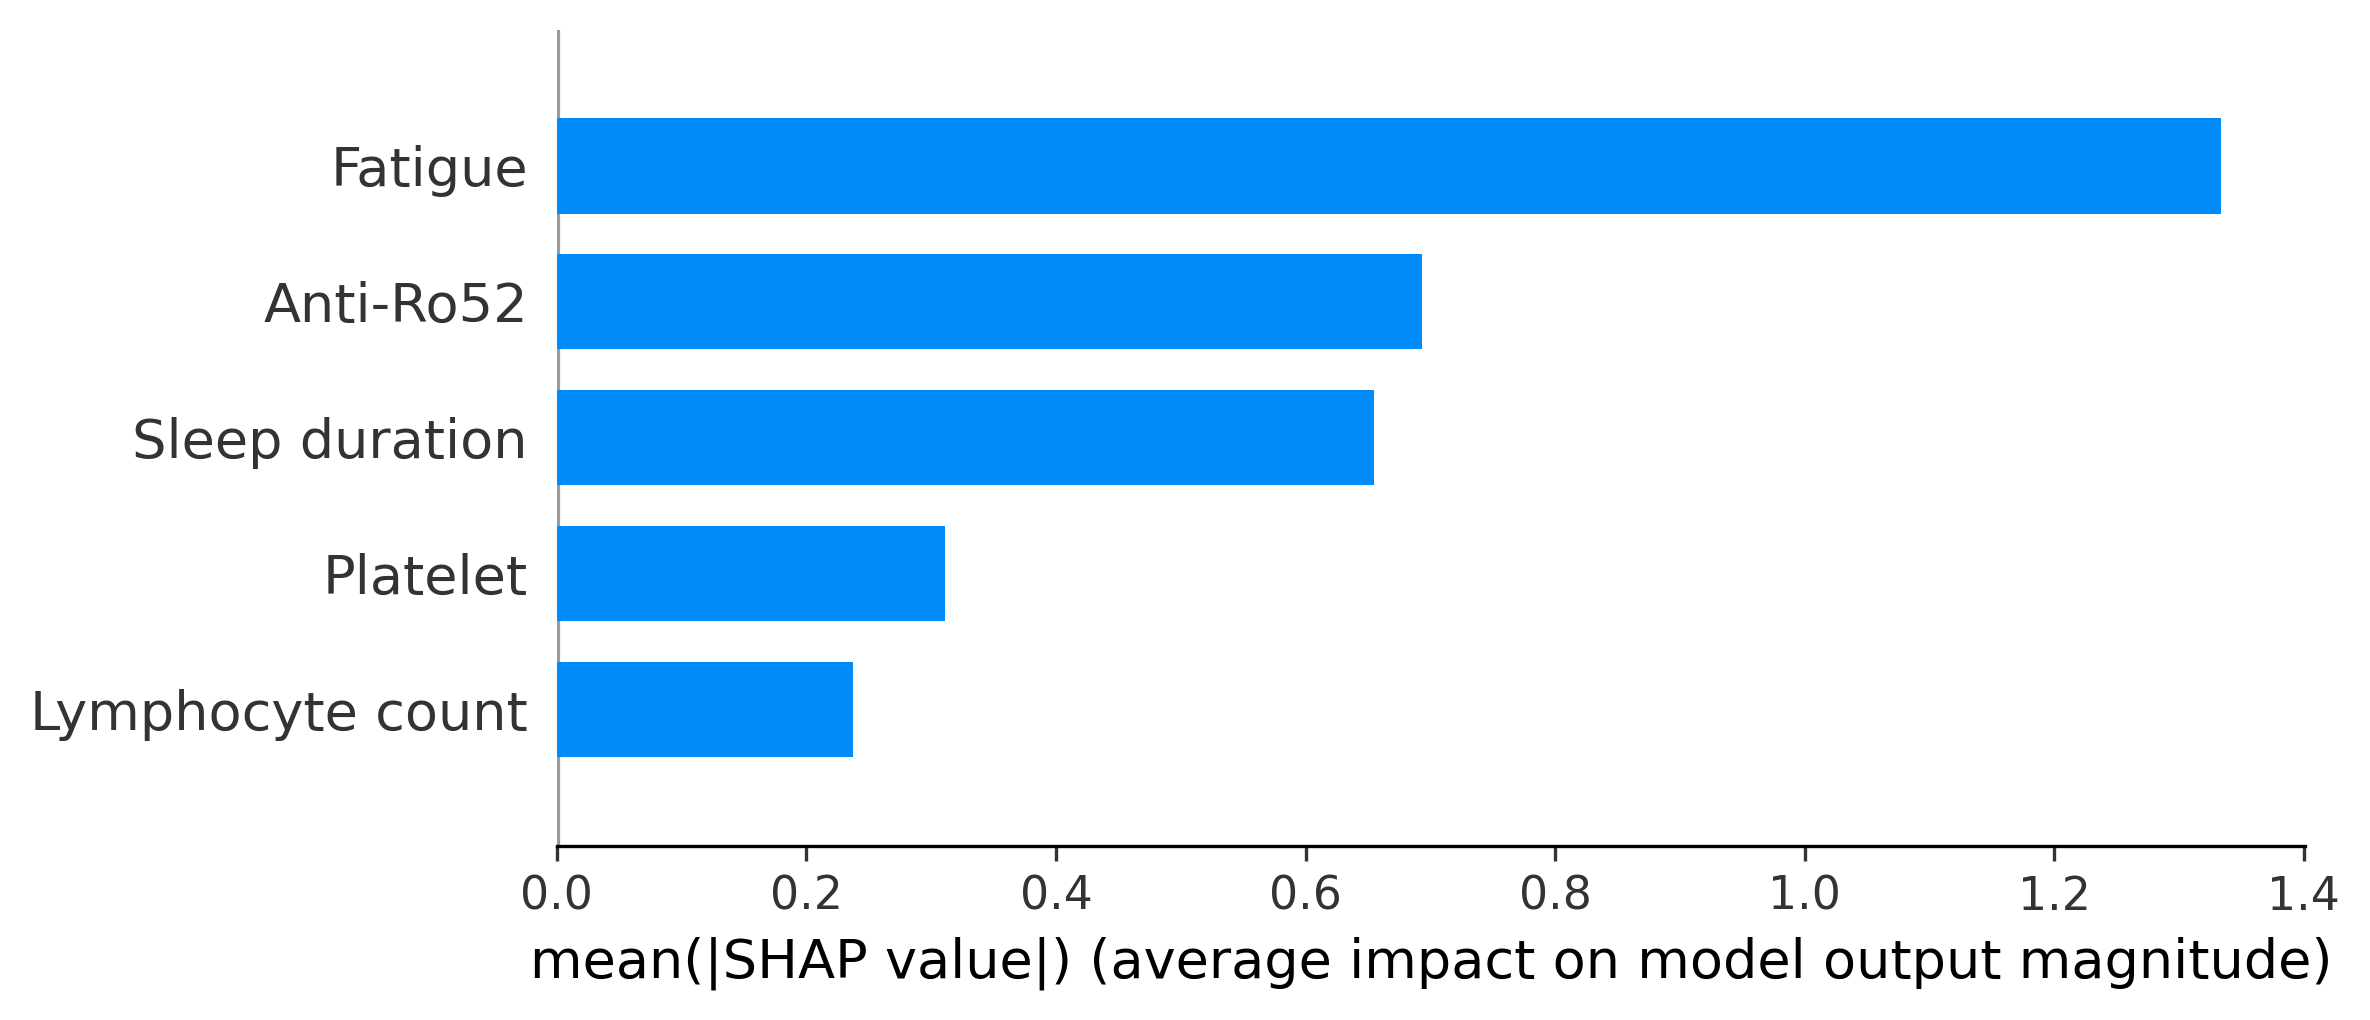

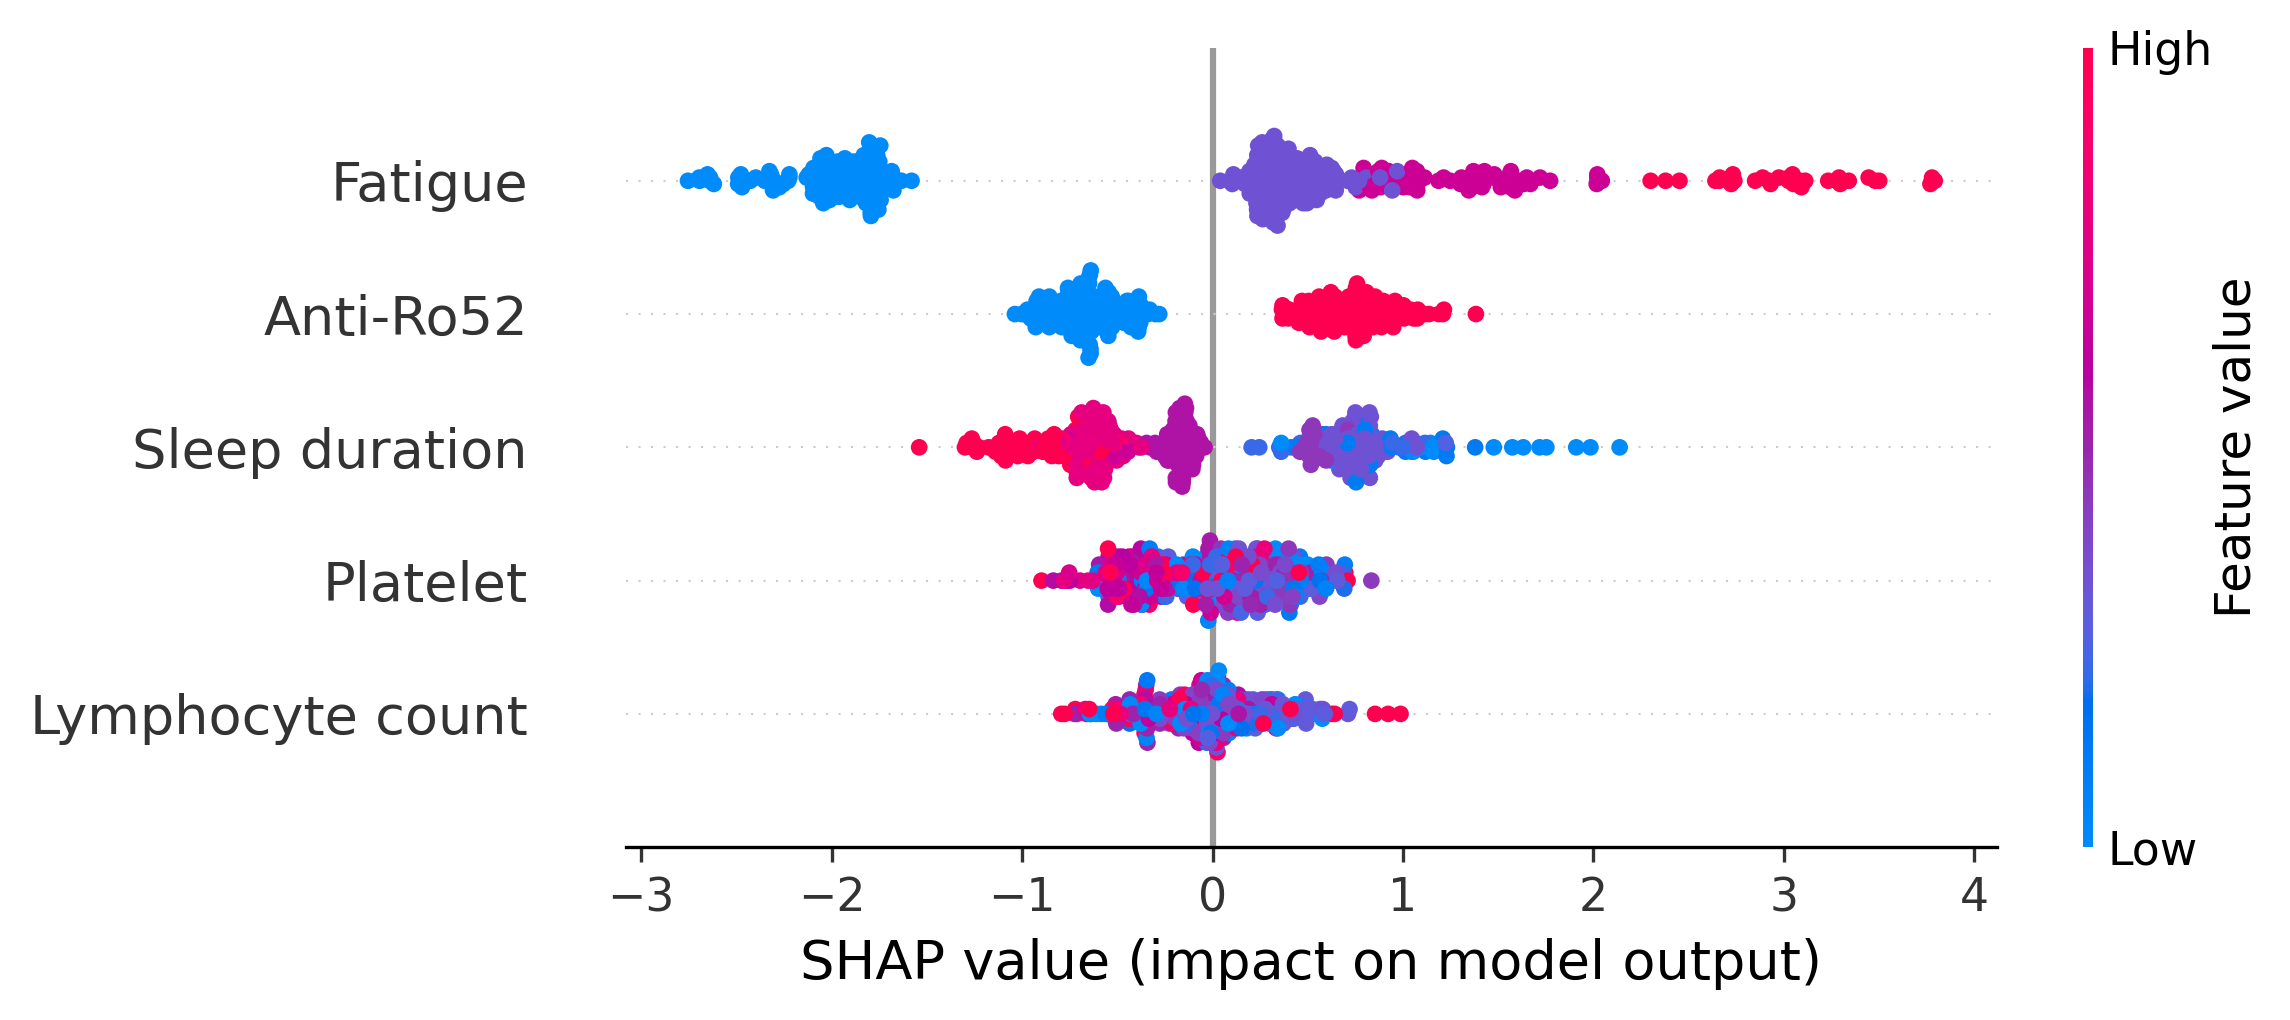

In [68]:
#plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置字体为黑体
#plt.rcParams['axes.unicode_minus'] = False # 显示负号
explainer_cat = shap.Explainer(cat2)
shap_values = explainer_cat(trainx_standard_1)
plt.figure(dpi=300)
#Plot shap beesworm
shap.summary_plot(shap_values,plot_type='bar',show=False)
#plt.savefig('D:\研究生课题\风湿免疫\手稿\结果\Figure\Figure4_a.tiff',dpi=300)
plt.figure(dpi=300)
shap.summary_plot(shap_values,plot_type='dot',show=False)
#plt.savefig('D:\研究生课题\风湿免疫\手稿\结果\Figure\Figure4_b.tiff',dpi=300)

LGBM

In [30]:
# 构建LightGBM数据集
train_data = lgb.Dataset(trainx_standard_1, label=trainy)
# 设置模型参数
param = {'num_class': 3, 'objective': 'multiclass','learning_rate': 0.02,'num_leaves': 30, 'metric': 'multi_logloss'}

# 训练模型
lgbm = lgb.train(param, train_data)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 5
[LightGBM] [Info] Start training from score -0.730287
[LightGBM] [Info] Start training from score -1.154852
[LightGBM] [Info] Start training from score -1.593934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [31]:
lgbm.predict(trainx_standard_1)

array([[0.09288992, 0.16933796, 0.73777212],
       [0.25010037, 0.41394638, 0.33595324],
       [0.332146  , 0.61944556, 0.04840844],
       ...,
       [0.9070469 , 0.07120946, 0.02174365],
       [0.23656954, 0.27098746, 0.492443  ],
       [0.15490303, 0.54604919, 0.29904778]])

In [32]:
y_prob_train_lgb = lgbm.predict(trainx_standard_1)
y_prob_test_lgb = lgbm.predict(testx_standard_1)

y_pred_train_lgb = [list(x).index(max(x)) for x in y_prob_train_lgb]
y_pred_test_lgb = [list(x).index(max(x)) for x in y_prob_test_lgb]

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


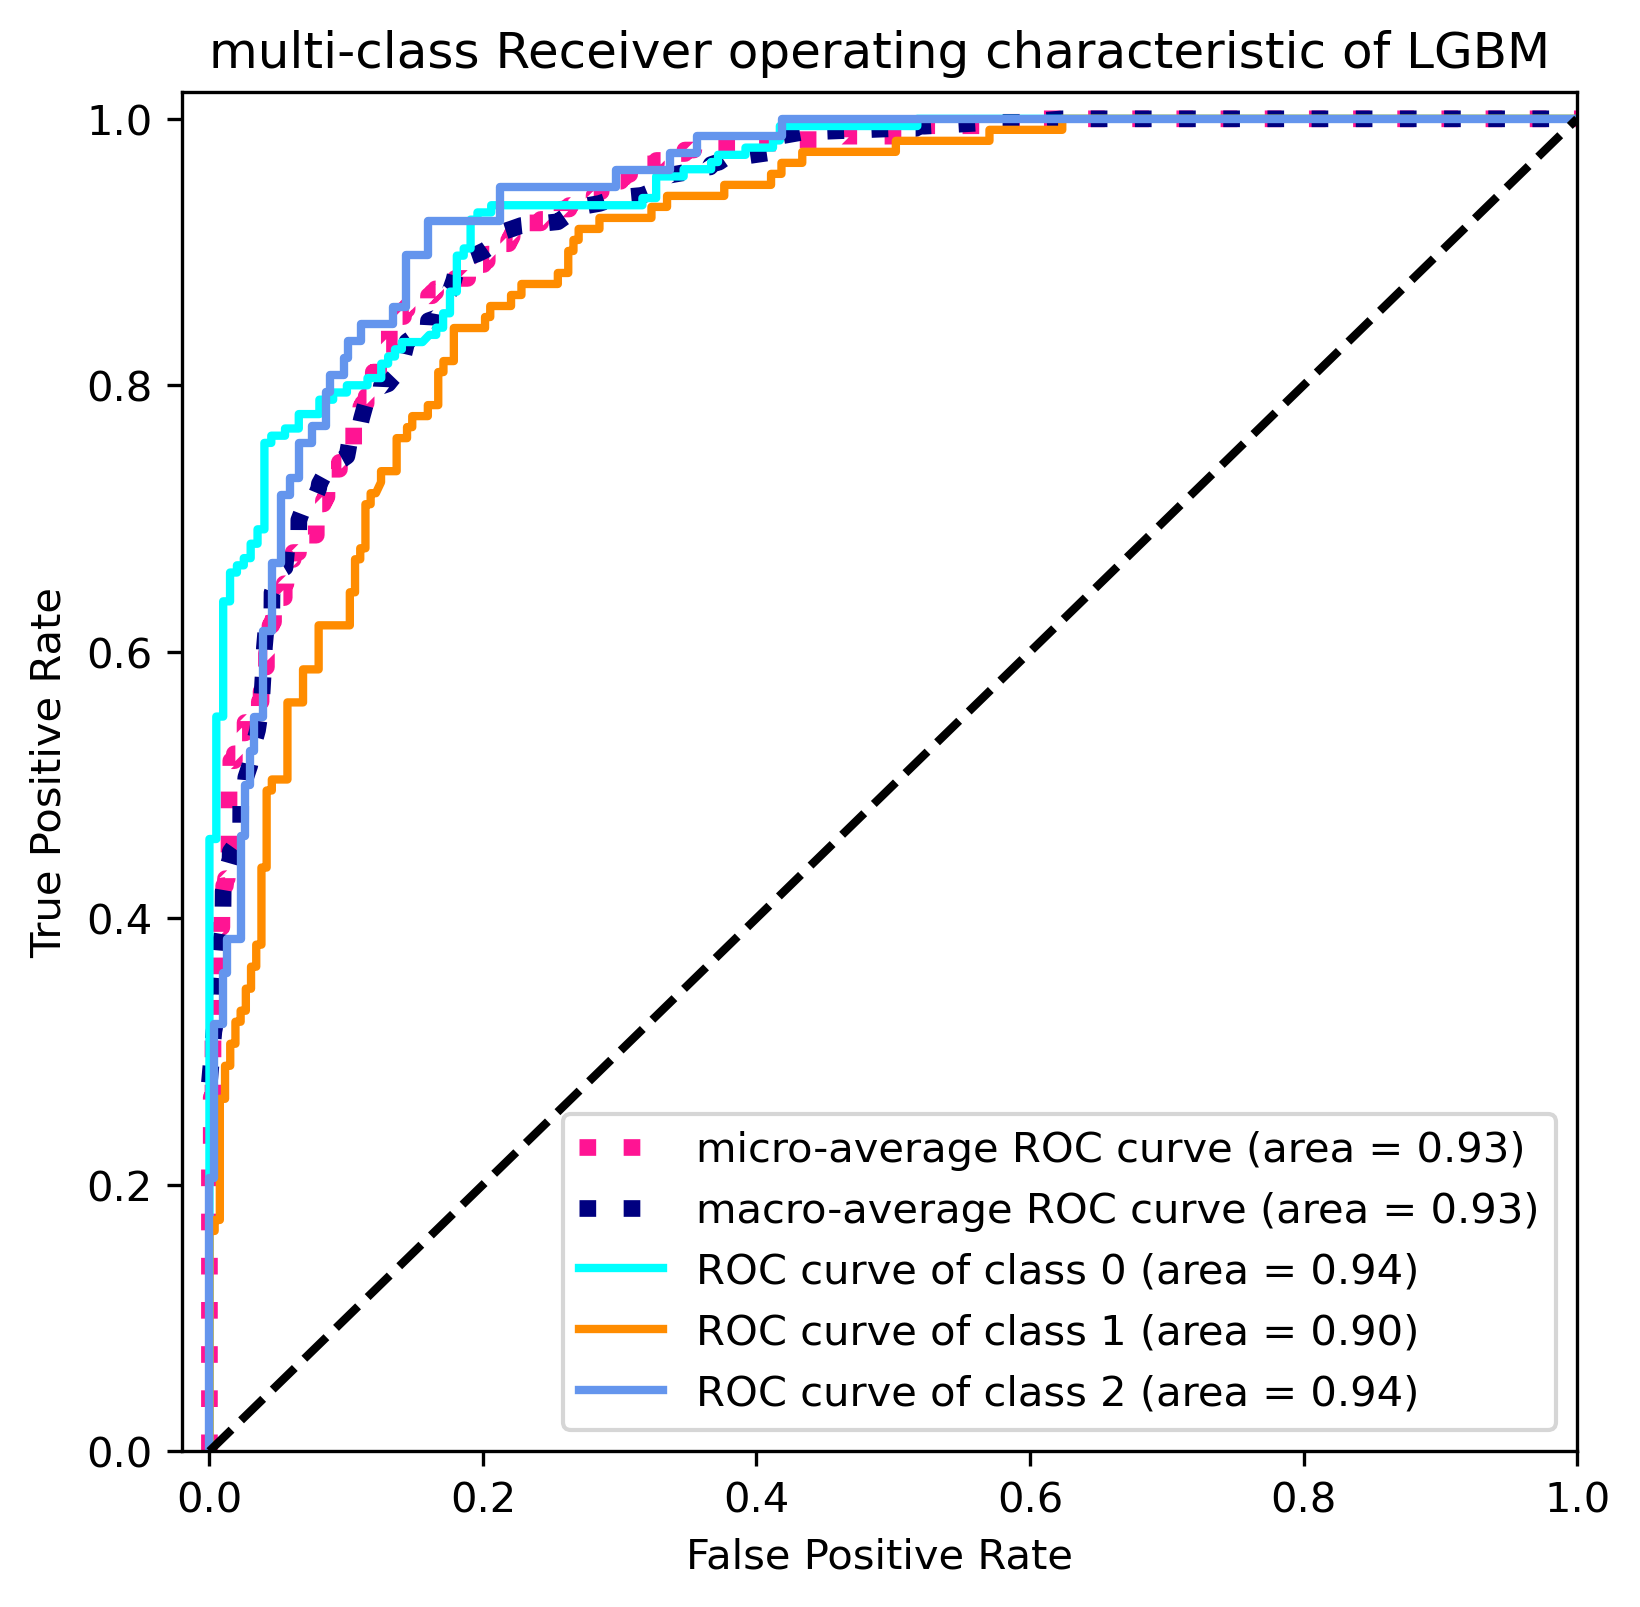

In [33]:
n_classes = trainy_bi.shape[1]
##训练集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(trainy_bi[:, i], y_prob_train_lgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(trainy_bi.ravel(), y_prob_train_lgb.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of LGBM')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_lgb_train.tiff',dpi=300)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


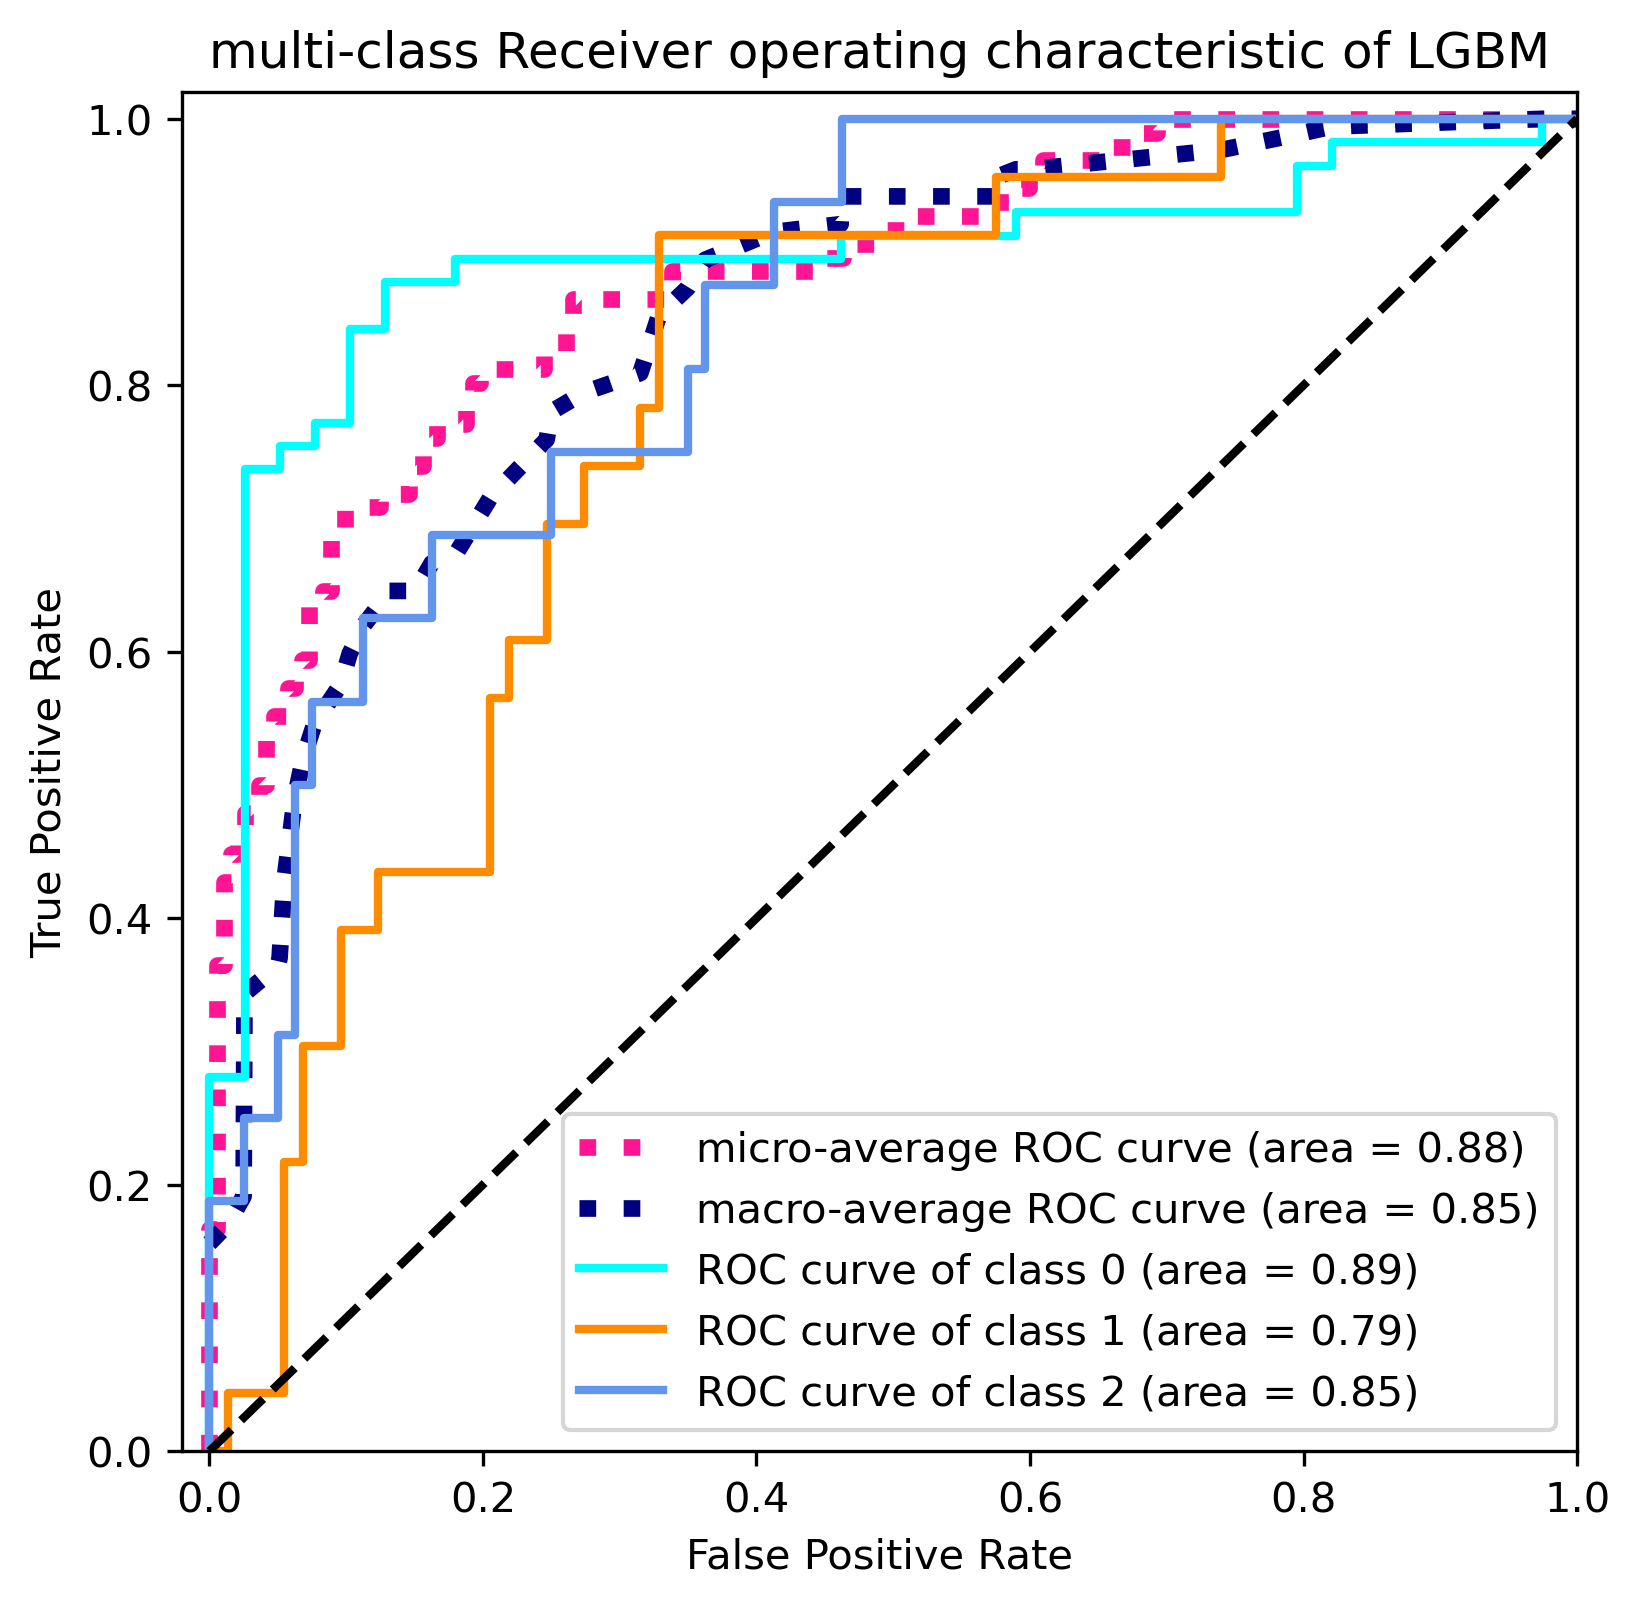

In [34]:
##测试集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy_bi[:, i], y_prob_test_lgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(testy_bi.ravel(), y_prob_test_lgb.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of LGBM')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_lgb_test.tiff',dpi=300)

In [35]:
confusion_lgb_mat1 = confusion_matrix(trainy, y_pred_train_lgb)
print("confusion_mat_train.shape : {}".format(confusion_lgb_mat1.shape))
print("confusion_mat_train:\n{}".format(confusion_lgb_mat1))

##测试集
print()
confusion_lgb_mat2 = confusion_matrix(testy, y_pred_test_lgb)
print("confusion_mat_test.shape : {}".format(confusion_lgb_mat2.shape))
print("confusion_mat_test:\n{}".format(confusion_lgb_mat2))

confusion_mat_train.shape : (3, 3)
confusion_mat_train:
[[161  20   4]
 [ 24  87  10]
 [  8  22  48]]

confusion_mat_test.shape : (3, 3)
confusion_mat_test:
[[50  5  2]
 [ 4 14  5]
 [ 3  5  8]]


[None, None, None, None, None, None]

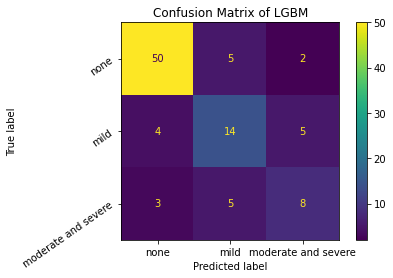

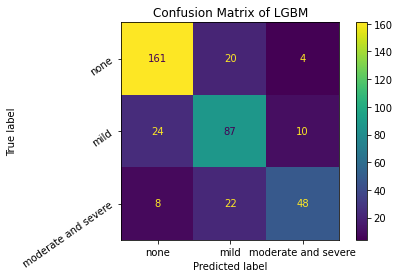

In [36]:
classes = ['none','mild','moderate and severe']
#fig = plt.figure(figsize=(15, 15))
disp2_lgb = ConfusionMatrixDisplay(confusion_matrix=confusion_lgb_mat2, display_labels=classes)
disp2_lgb.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of LGBM')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp2_lgb.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_lgb_test.tiff',figsize=(10,10),dpi=300)


disp1_lgb = ConfusionMatrixDisplay(confusion_matrix=confusion_lgb_mat1, display_labels=classes)
disp1_lgb.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of LGBM')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp1_lgb.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_lgb_train.tiff',dpi=300)

In [37]:
##训练集
accuracy_train_lgb = metrics.accuracy_score(trainy,y_pred_train_lgb)
print("accuracy_train_lgb:{:.3}".format(accuracy_train_lgb))
print()

##print("参数为None：输出每一类的指标")
none_p_train_lgb = metrics.precision_score(trainy,y_pred_train_lgb, average=None)
none_r_train_lgb = metrics.recall_score(trainy,y_pred_train_lgb, average=None)
none_f1_train_lgb = metrics.f1_score(trainy,y_pred_train_lgb, average=None)
np.set_printoptions(precision=3) 
print("none_p_train_lgb:{}".format(none_p_train_lgb))
print("none_r_train_lgb:{}".format(none_r_train_lgb))
print("none_f1_train_lgb:{}".format(none_f1_train_lgb))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_train_lgb = metrics.precision_score(trainy,y_pred_train_lgb, average='macro')
macro_r_train_lgb = metrics.recall_score(trainy,y_pred_train_lgb, average='macro')
macro_f1_train_lgb = metrics.f1_score(trainy,y_pred_train_lgb, average='macro')
print("macro_p_train_lgb:{:.3}".format(macro_p_train_lgb))
print("macro_r_train_lgb:{:.3}".format(macro_r_train_lgb))
print("macro_f1_train_lgb:{:.3}".format(macro_f1_train_lgb))
print()

##print("参数为micro")
micro_p_train_lgb = metrics.precision_score(trainy,y_pred_train_lgb, average='micro')
micro_r_train_lgb = metrics.recall_score(trainy,y_pred_train_lgb, average='micro')
micro_f1_train_lgb = metrics.f1_score(trainy,y_pred_train_lgb, average='micro')
print("micro_p_train_lgb:{:.3}".format(micro_p_train_lgb))
print("micro_r_train_lgb:{:.3}".format(micro_r_train_lgb))
print("micro_f1_train_lgb:{:.3}".format(micro_f1_train_lgb))
print()

##print("参数为weighted")
weighted_p_train_lgb = metrics.precision_score(trainy,y_pred_train_lgb, average='weighted')
weighted_r_train_lgb = metrics.recall_score(trainy,y_pred_train_lgb, average='weighted')
weighted_f1_train_lgb = metrics.f1_score(trainy,y_pred_train_lgb, average='weighted')
print("weighted_p_train_lgb:{:.3}".format(weighted_p_train_lgb))
print("weighted_r_train_lgb:{:.3}".format(weighted_r_train_lgb))
print("weighted_f1_train_lgb:{:.3}".format(weighted_f1_train_lgb))
print()

##马修斯相关系数
mcc_lgb_train = matthews_corrcoef(trainy, y_pred_train_lgb)
print("mcc_train_lgb:{:.3}".format(mcc_lgb_train))
print()

##kappa
matrix1_lgb = np.array(confusion_lgb_mat1)
matrix2_lgb = np.array(confusion_lgb_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_train_lgb:{:.3}".format(kappa(matrix1_lgb)))

accuracy_train_lgb:0.771

none_p_train_lgb:[0.834 0.674 0.774]
none_r_train_lgb:[0.87  0.719 0.615]
none_f1_train_lgb:[0.852 0.696 0.686]

macro_p_train_lgb:0.761
macro_r_train_lgb:0.735
macro_f1_train_lgb:0.745

micro_p_train_lgb:0.771
micro_r_train_lgb:0.771
micro_f1_train_lgb:0.771

weighted_p_train_lgb:0.772
weighted_r_train_lgb:0.771
weighted_f1_train_lgb:0.769

mcc_train_lgb:0.631

kappa_train_lgb:0.63


In [38]:
##训练集
accuracy_test_lgb = metrics.accuracy_score(testy,y_pred_test_lgb)
print("accuracy_test_lgb:{:.3}".format(accuracy_test_lgb))
print()

##print("参数为None：输出每一类的指标")
none_p_test_lgb = metrics.precision_score(testy,y_pred_test_lgb, average=None)
none_r_test_lgb = metrics.recall_score(testy,y_pred_test_lgb, average=None)
none_f1_test_lgb = metrics.f1_score(testy,y_pred_test_lgb, average=None)
np.set_printoptions(precision=3) 
print("none_p_test_lgb:{}".format(none_p_test_lgb))
print("none_r_test_lgb:{}".format(none_r_test_lgb))
print("none_f1_test_lgb:{}".format(none_f1_test_lgb))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_test_lgb = metrics.precision_score(testy,y_pred_test_lgb, average='macro')
macro_r_test_lgb = metrics.recall_score(testy,y_pred_test_lgb, average='macro')
macro_f1_test_lgb = metrics.f1_score(testy,y_pred_test_lgb, average='macro')
print("macro_p_test_lgb:{:.3}".format(macro_p_test_lgb))
print("macro_r_test_lgb:{:.3}".format(macro_r_test_lgb))
print("macro_f1_test_lgb:{:.3}".format(macro_f1_test_lgb))
print()

##print("参数为micro")
micro_p_train_lgb = metrics.precision_score(trainy,y_pred_train_lgb, average='micro')
micro_r_train_lgb = metrics.recall_score(trainy,y_pred_train_lgb, average='micro')
micro_f1_train_lgb = metrics.f1_score(trainy,y_pred_train_lgb, average='micro')
print("micro_p_train_lgb:{:.3}".format(micro_p_train_lgb))
print("micro_r_train_lgb:{:.3}".format(micro_r_train_lgb))
print("micro_f1_train_lgb:{:.3}".format(micro_f1_train_lgb))
print()

##print("参数为weighted")
weighted_p_test_lgb = metrics.precision_score(testy,y_pred_test_lgb, average='weighted')
weighted_r_test_lgb = metrics.recall_score(testy,y_pred_test_lgb, average='weighted')
weighted_f1_test_lgb = metrics.f1_score(testy,y_pred_test_lgb, average='weighted')
print("weighted_p_test_lgb:{:.3}".format(weighted_p_test_lgb))
print("weighted_r_test_lgb:{:.3}".format(weighted_r_test_lgb))
print("weighted_f1_test_lgb:{:.3}".format(weighted_f1_test_lgb))
print()

##马修斯相关系数
mcc_lgb_test = matthews_corrcoef(testy, y_pred_test_lgb)
print("mcc_test_lgb:{:.3}".format(mcc_lgb_test))
print()

##kappa
matrix1_lgb = np.array(confusion_lgb_mat1)
matrix2_lgb = np.array(confusion_lgb_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_test_lgb:{:.3}".format(kappa(matrix2_lgb)))

accuracy_test_lgb:0.75

none_p_test_lgb:[0.877 0.583 0.533]
none_r_test_lgb:[0.877 0.609 0.5  ]
none_f1_test_lgb:[0.877 0.596 0.516]

macro_p_test_lgb:0.665
macro_r_test_lgb:0.662
macro_f1_test_lgb:0.663

micro_p_train_lgb:0.771
micro_r_train_lgb:0.771
micro_f1_train_lgb:0.771

weighted_p_test_lgb:0.749
weighted_r_test_lgb:0.75
weighted_f1_test_lgb:0.75

mcc_test_lgb:0.555

kappa_test_lgb:0.555


In [43]:
##建立新的二元分类器

train_data2 = lgb.Dataset(trainx_standard_1, label=trainy2)
# 设置模型参数
param2 = { 'objective': 'binary','learning_rate': 0.02,'num_leaves': 30, 'metric': 'binary_logloss'}

# 训练模型
lgbm2 = lgb.train(param2, train_data2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 185
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518229 -> initscore=0.072949
[LightGBM] [Info] Start training from score 0.072949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [44]:
y_prob_train_lgb2 = lgbm2.predict(trainx_standard_1)
y_prob_test_lgb2 = lgbm2.predict(testx_standard_1)


In [45]:
# Predict probabilities for the positive class
y_pred_raw = lgbm2.predict(trainx_standard_1)
y_pred_proba_lgbm = 1 / (1 + np.exp(-y_pred_raw))

# Compute the FPR and TPR for different thresholds
fpr, tpr, thresholds = roc_curve(trainy2, y_prob_train_lgb2)

# Calculate the Youden's index for each threshold
youden_scores = tpr - fpr

# Find the index of the maximum Youden's index
optimal_threshold_index = np.argmax(youden_scores)

# Get the optimal threshold
optimal_threshold = thresholds[optimal_threshold_index]

print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.4250183239359601


In [46]:
threshold = 0.425
y_pred_train_lgb2 = (y_prob_train_lgb2  > threshold).astype(int)
y_pred_test_lgb2 = (y_prob_test_lgb2  > threshold).astype(int)

RF

In [44]:
rfc = RandomForestClassifier(n_estimators=450,max_depth=6,min_samples_leaf=12,min_samples_split=8,random_state=88)
rfc.fit(trainx_standard_1, trainy)

RandomForestClassifier(max_depth=6, min_samples_leaf=12, min_samples_split=8,
                       n_estimators=450, random_state=88)

In [45]:
# 设置种类
n_classes = trainy_bi.shape[1]
y_prob_train_rfc = rfc.predict_proba(trainx_standard_1)
y_prob_test_rfc = rfc.predict_proba(testx_standard_1)
y_pred_train_rfc = rfc.predict(trainx_standard_1)
y_pred_test_rfc = rfc.predict(testx_standard_1)

In [46]:
y_pred_test_rfc

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       2., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 2., 1., 0., 0.,
       0., 1., 0., 1., 2., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.])

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


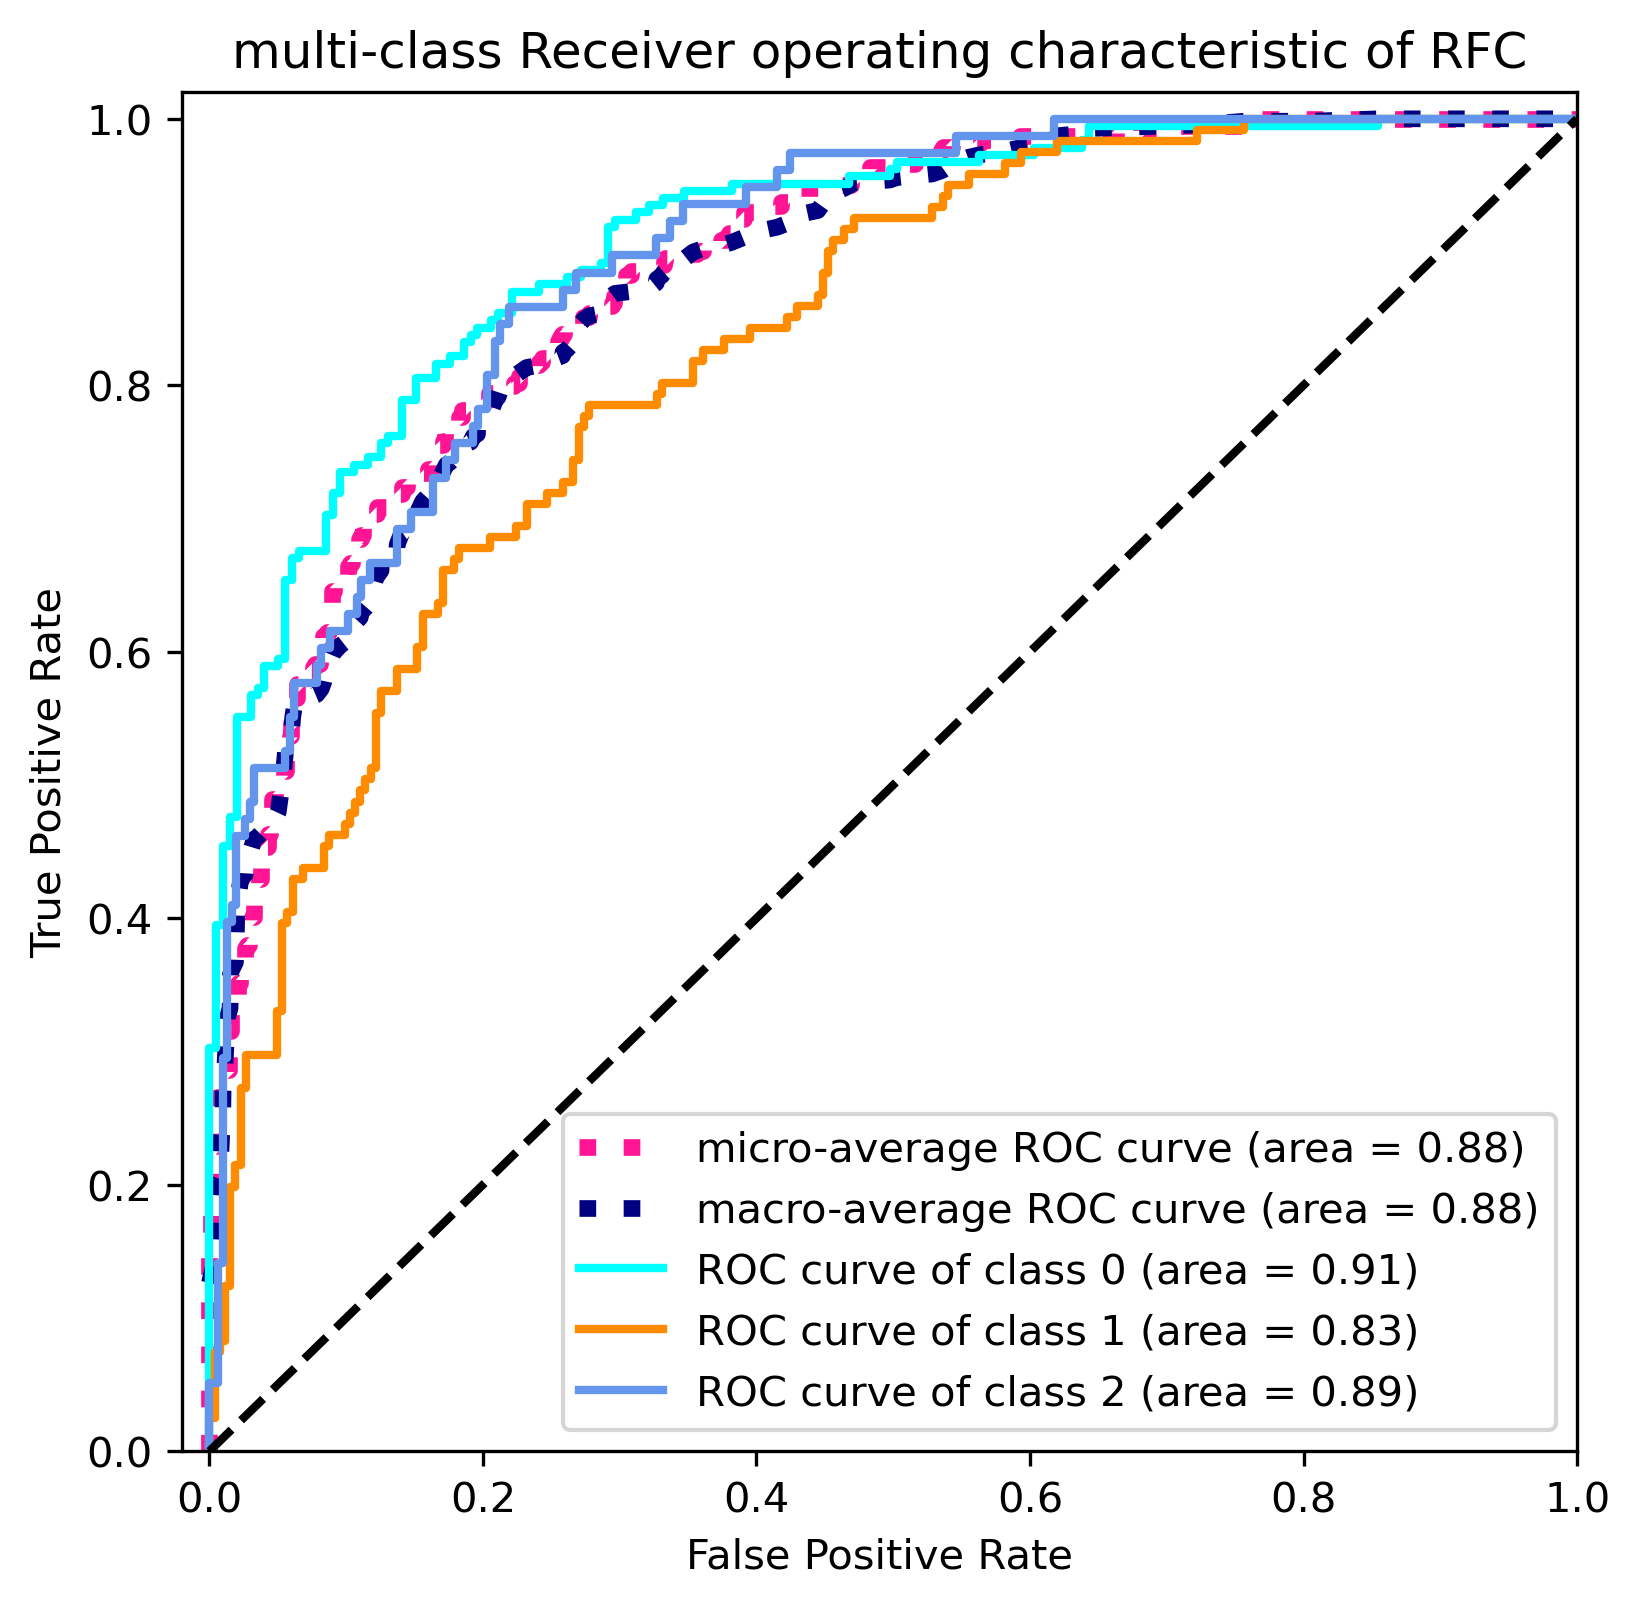

In [47]:
##训练集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(trainy_bi[:, i], y_prob_train_rfc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(trainy_bi.ravel(), y_prob_train_rfc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of RFC')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_rfc_train.tiff',dpi=300)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


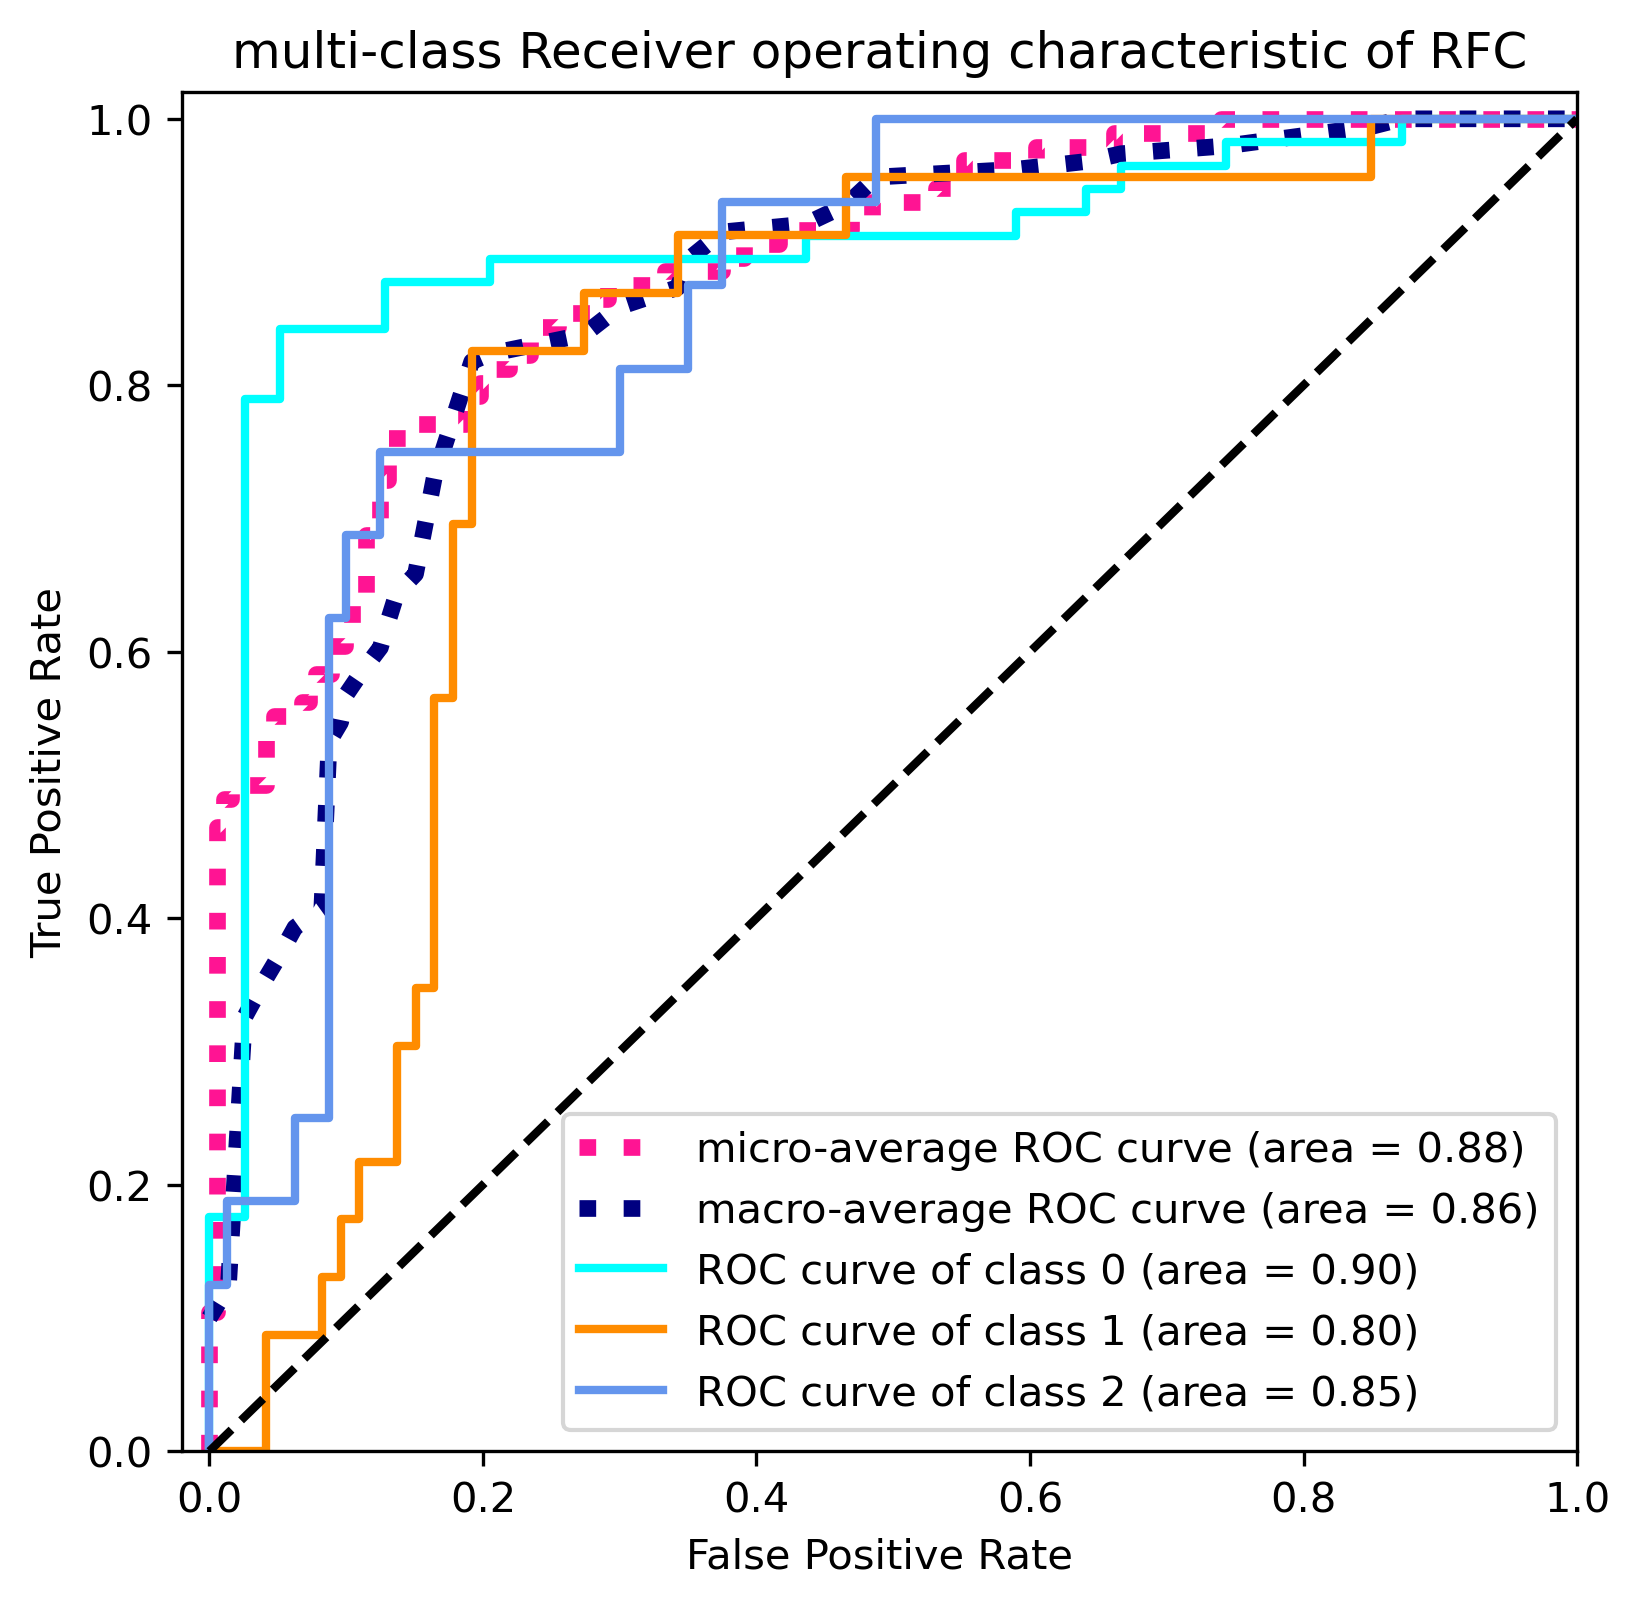

In [48]:
##测试集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy_bi[:, i], y_prob_test_rfc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(testy_bi.ravel(), y_prob_test_rfc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of RFC')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_rfc_test.tiff',dpi=300)

In [49]:
confusion_rfc_mat1 = confusion_matrix(trainy, y_pred_train_rfc)
print("confusion_mat_train.shape : {}".format(confusion_rfc_mat1.shape))
print("confusion_mat_train:\n{}".format(confusion_rfc_mat1))

##测试集
print()
confusion_rfc_mat2 = confusion_matrix(testy, y_pred_test_rfc)
print("confusion_mat_test.shape : {}".format(confusion_rfc_mat2.shape))
print("confusion_mat_test:\n{}".format(confusion_rfc_mat2))

confusion_mat_train.shape : (3, 3)
confusion_mat_train:
[[153  31   1]
 [ 30  84   7]
 [ 12  29  37]]

confusion_mat_test.shape : (3, 3)
confusion_mat_test:
[[51  5  1]
 [ 4 17  2]
 [ 4  8  4]]


[None, None, None, None, None, None]

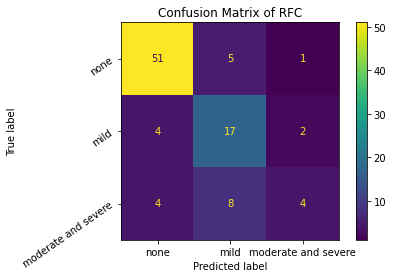

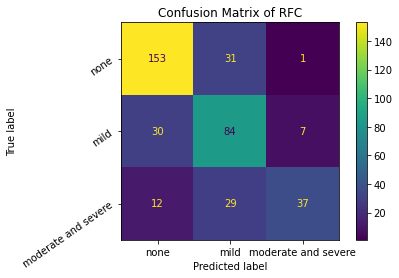

In [50]:
classes = ['none','mild','moderate and severe']
#fig = plt.figure(figsize=(15, 15))
disp2_rfc = ConfusionMatrixDisplay(confusion_matrix=confusion_rfc_mat2, display_labels=classes)
disp2_rfc.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of RFC')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp2_rfc.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_rfc_test.tiff',figsize=(10,10),dpi=300)


disp1_rfc = ConfusionMatrixDisplay(confusion_matrix=confusion_rfc_mat1, display_labels=classes)
disp1_rfc.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of RFC')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp1_rfc.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_rfc_train.tiff',dpi=300)

In [51]:
##训练集
accuracy_train_rfc = metrics.accuracy_score(trainy,y_pred_train_rfc)
print("accuracy_train_rfc:{:.3}".format(accuracy_train_rfc))
print()

##print("参数为None：输出每一类的指标")
none_p_train_rfc = metrics.precision_score(trainy,y_pred_train_rfc, average=None)
none_r_train_rfc = metrics.recall_score(trainy,y_pred_train_rfc, average=None)
none_f1_train_rfc = metrics.f1_score(trainy,y_pred_train_rfc, average=None)
np.set_printoptions(precision=3) 
print("none_p_train_rfc:{}".format(none_p_train_rfc))
print("none_r_train_rfc:{}".format(none_r_train_rfc))
print("none_f1_train_rfc:{}".format(none_f1_train_rfc))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_train_rfc = metrics.precision_score(trainy,y_pred_train_rfc, average='macro')
macro_r_train_rfc = metrics.recall_score(trainy,y_pred_train_rfc, average='macro')
macro_f1_train_rfc = metrics.f1_score(trainy,y_pred_train_rfc, average='macro')
print("macro_p_train_rfc:{:.3}".format(macro_p_train_rfc))
print("macro_r_train_rfc:{:.3}".format(macro_r_train_rfc))
print("macro_f1_train_rfc:{:.3}".format(macro_f1_train_rfc))
print()

##print("参数为micro")
micro_p_train_rfc = metrics.precision_score(trainy,y_pred_train_rfc, average='micro')
micro_r_train_rfc = metrics.recall_score(trainy,y_pred_train_rfc, average='micro')
micro_f1_train_rfc = metrics.f1_score(trainy,y_pred_train_rfc, average='micro')
print("micro_p_train_rfc:{:.3}".format(micro_p_train_rfc))
print("micro_r_train_rfc:{:.3}".format(micro_r_train_rfc))
print("micro_f1_train_rfc:{:.3}".format(micro_f1_train_rfc))
print()

##print("参数为weighted")
weighted_p_train_rfc = metrics.precision_score(trainy,y_pred_train_rfc, average='weighted')
weighted_r_train_rfc = metrics.recall_score(trainy,y_pred_train_rfc, average='weighted')
weighted_f1_train_rfc = metrics.f1_score(trainy,y_pred_train_rfc, average='weighted')
print("weighted_p_train_rfc:{:.3}".format(weighted_p_train_rfc))
print("weighted_r_train_rfc:{:.3}".format(weighted_r_train_rfc))
print("weighted_f1_train_rfc:{:.3}".format(weighted_f1_train_rfc))
print()

##马修斯相关系数
mcc_rfc_train = matthews_corrcoef(trainy, y_pred_train_rfc)
print("mcc_train_rfc:{:.3}".format(mcc_rfc_train))
print()

##kappa
matrix1_rfc = np.array(confusion_rfc_mat1)
matrix2_rfc = np.array(confusion_rfc_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_train_rfc:{:.3}".format(kappa(matrix1_rfc)))

accuracy_train_rfc:0.714

none_p_train_rfc:[0.785 0.583 0.822]
none_r_train_rfc:[0.827 0.694 0.474]
none_f1_train_rfc:[0.805 0.634 0.602]

macro_p_train_rfc:0.73
macro_r_train_rfc:0.665
macro_f1_train_rfc:0.68

micro_p_train_rfc:0.714
micro_r_train_rfc:0.714
micro_f1_train_rfc:0.714

weighted_p_train_rfc:0.729
weighted_r_train_rfc:0.714
weighted_f1_train_rfc:0.71

mcc_train_rfc:0.538

kappa_train_rfc:0.533


In [52]:
##测试集
accuracy_test_rfc = metrics.accuracy_score(testy,y_pred_test_rfc)
print("accuracy_test_rfc:{:.3}".format(accuracy_test_rfc))
print()

##print("参数为None：输出每一类的指标")
none_p_test_rfc = metrics.precision_score(testy,y_pred_test_rfc, average=None)
none_r_test_rfc = metrics.recall_score(testy,y_pred_test_rfc, average=None)
none_f1_test_rfc = metrics.f1_score(testy,y_pred_test_rfc, average=None)
np.set_printoptions(precision=3) 
print("none_p_test_rfc:{}".format(none_p_test_rfc))
print("none_r_test_rfc:{}".format(none_r_test_rfc))
print("none_f1_test_rfc:{}".format(none_f1_test_rfc))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_test_rfc = metrics.precision_score(testy,y_pred_test_rfc, average='macro')
macro_r_test_rfc = metrics.recall_score(testy,y_pred_test_rfc, average='macro')
macro_f1_test_rfc = metrics.f1_score(testy,y_pred_test_rfc, average='macro')
print("macro_p_test_rfc:{:.3}".format(macro_p_test_rfc))
print("macro_r_test_rfc:{:.3}".format(macro_r_test_rfc))
print("macro_f1_test_rfc:{:.3}".format(macro_f1_test_rfc))
print()

##print("参数为micro")
micro_p_test_rfc = metrics.precision_score(testy,y_pred_test_rfc, average='micro')
micro_r_test_rfc = metrics.recall_score(testy,y_pred_test_rfc, average='micro')
micro_f1_test_rfc = metrics.f1_score(testy,y_pred_test_rfc, average='micro')
print("micro_p_test_rfc:{:.3}".format(micro_p_test_rfc))
print("micro_r_test_rfc:{:.3}".format(micro_r_train_rfc))
print("micro_f1_test_rfc:{:.3}".format(micro_f1_train_rfc))
print()

##print("参数为weighted")
weighted_p_test_rfc = metrics.precision_score(testy,y_pred_test_rfc, average='weighted')
weighted_r_test_rfc = metrics.recall_score(testy,y_pred_test_rfc, average='weighted')
weighted_f1_test_rfc = metrics.f1_score(testy,y_pred_test_rfc, average='weighted')
print("weighted_p_test_rfc:{:.3}".format(weighted_p_test_rfc))
print("weighted_r_test_rfc:{:.3}".format(weighted_r_test_rfc))
print("weighted_f1_test_rfc:{:.3}".format(weighted_f1_test_rfc))
print()

##马修斯相关系数
mcc_rfc_test = matthews_corrcoef(testy, y_pred_test_rfc)
print("mcc_test_rfc:{:.3}".format(mcc_rfc_test))
print()

##kappa
matrix1_rfc = np.array(confusion_rfc_mat1)
matrix2_rfc = np.array(confusion_rfc_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_test_rfc:{:.3}".format(kappa(matrix2_rfc)))

accuracy_test_rfc:0.75

none_p_test_rfc:[0.864 0.567 0.571]
none_r_test_rfc:[0.895 0.739 0.25 ]
none_f1_test_rfc:[0.879 0.642 0.348]

macro_p_test_rfc:0.668
macro_r_test_rfc:0.628
macro_f1_test_rfc:0.623

micro_p_test_rfc:0.75
micro_r_test_rfc:0.714
micro_f1_test_rfc:0.714

weighted_p_test_rfc:0.744
weighted_r_test_rfc:0.75
weighted_f1_test_rfc:0.734

mcc_test_rfc:0.552

kappa_test_rfc:0.544


In [53]:
rfc.n_classes_

3

LR

In [35]:
lr = LogisticRegression(penalty='l2',multi_class='auto')
lr.fit(trainx_standard_1, trainy)

LogisticRegression()

In [36]:
# 设置种类
n_classes = trainy_bi.shape[1]
y_prob_train_lr = lr.predict_proba(trainx_standard_1)
y_prob_test_lr = lr.predict_proba(testx_standard_1)
y_pred_train_lr = lr.predict(trainx_standard_1)
y_pred_test_lr = lr.predict(testx_standard_1)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


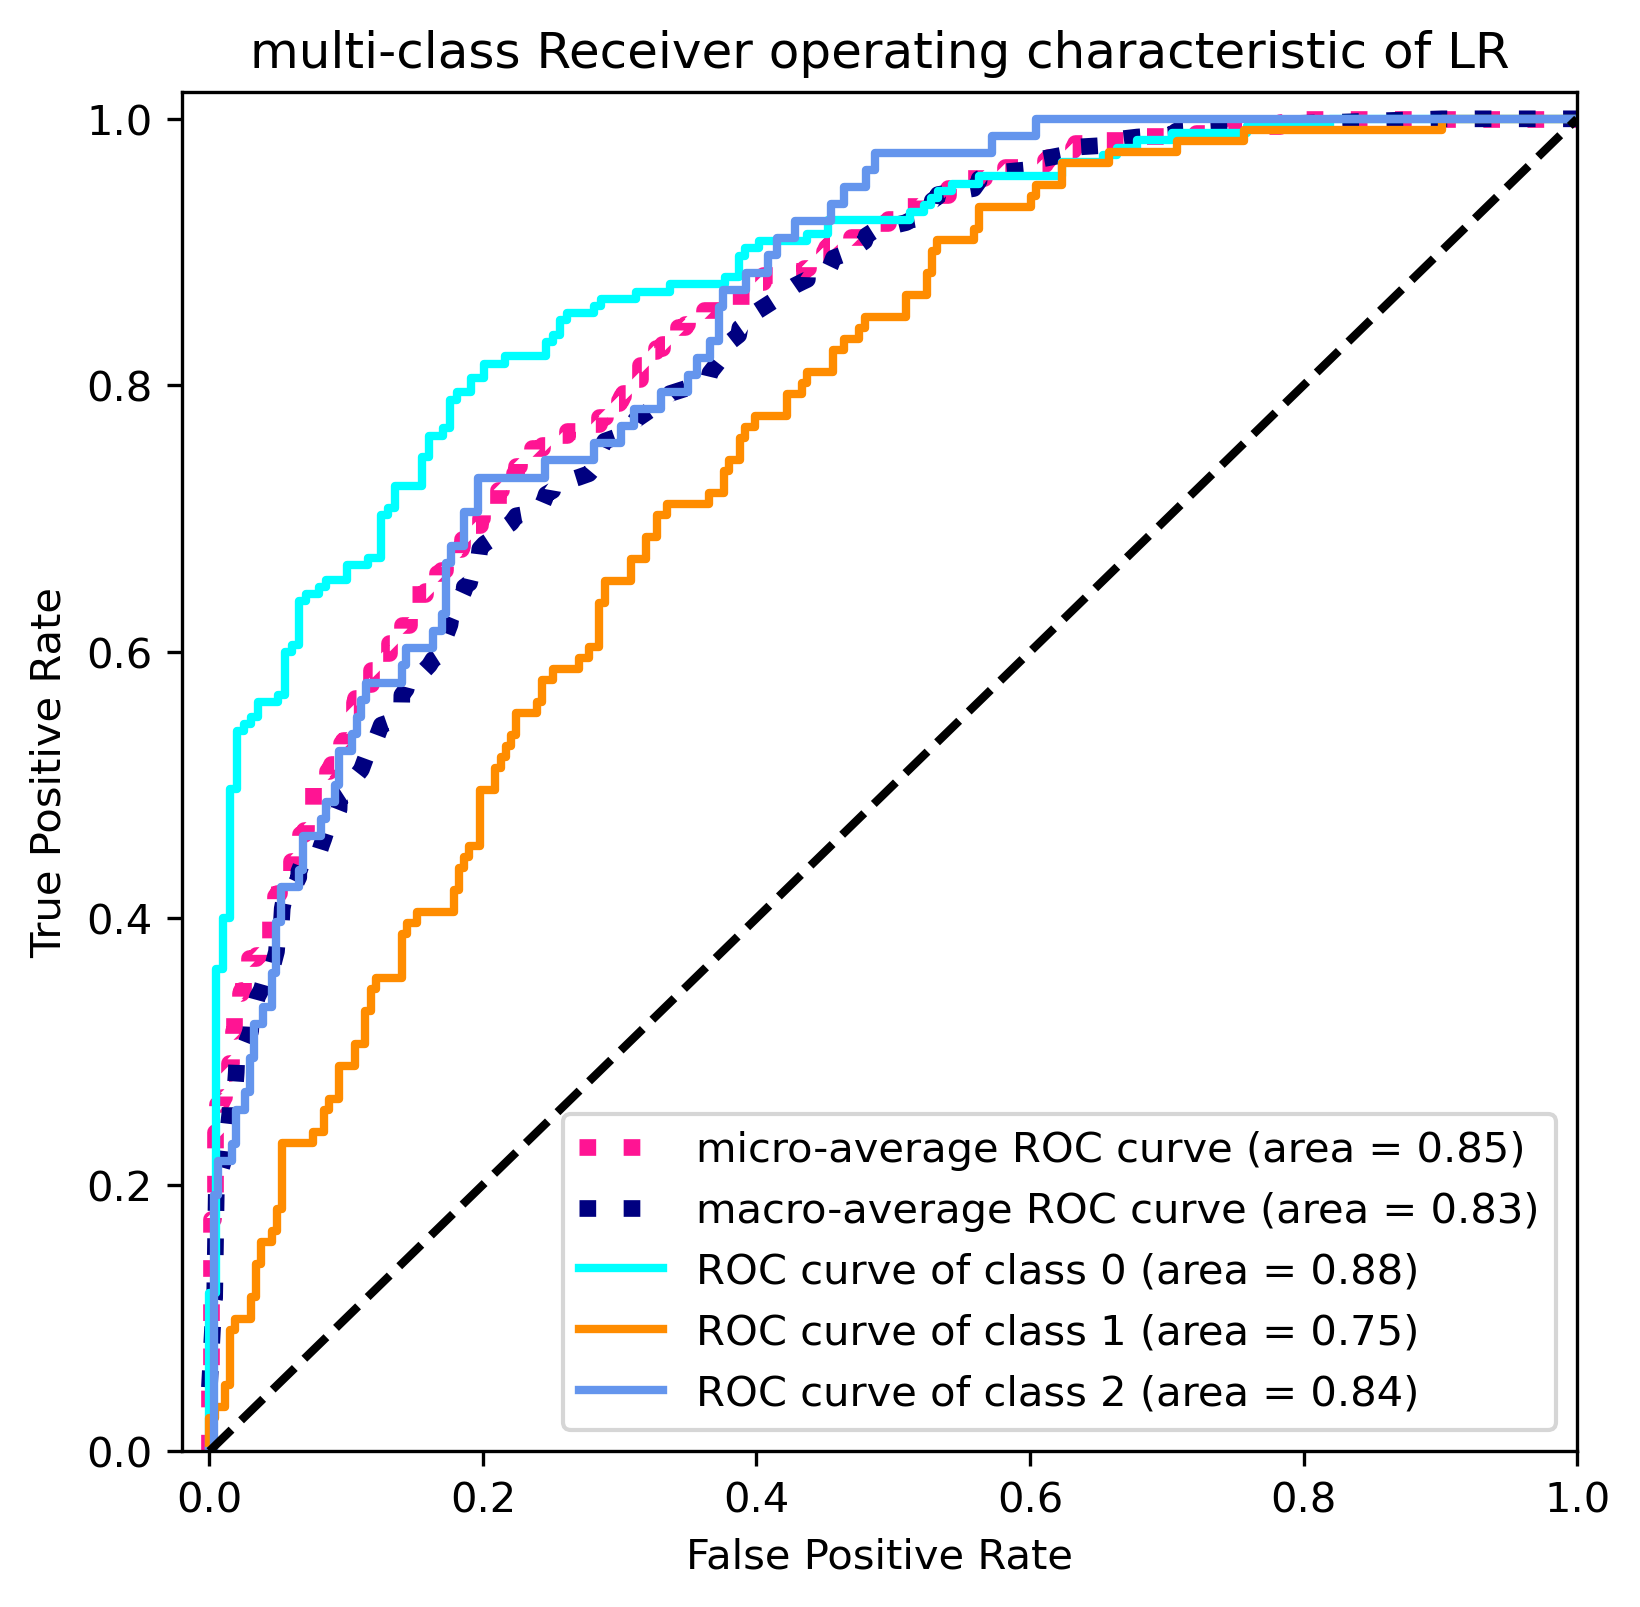

In [37]:
##训练集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(trainy_bi[:, i], y_prob_train_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(trainy_bi.ravel(), y_prob_train_lr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of LR')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_lr_train.tiff',dpi=300)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


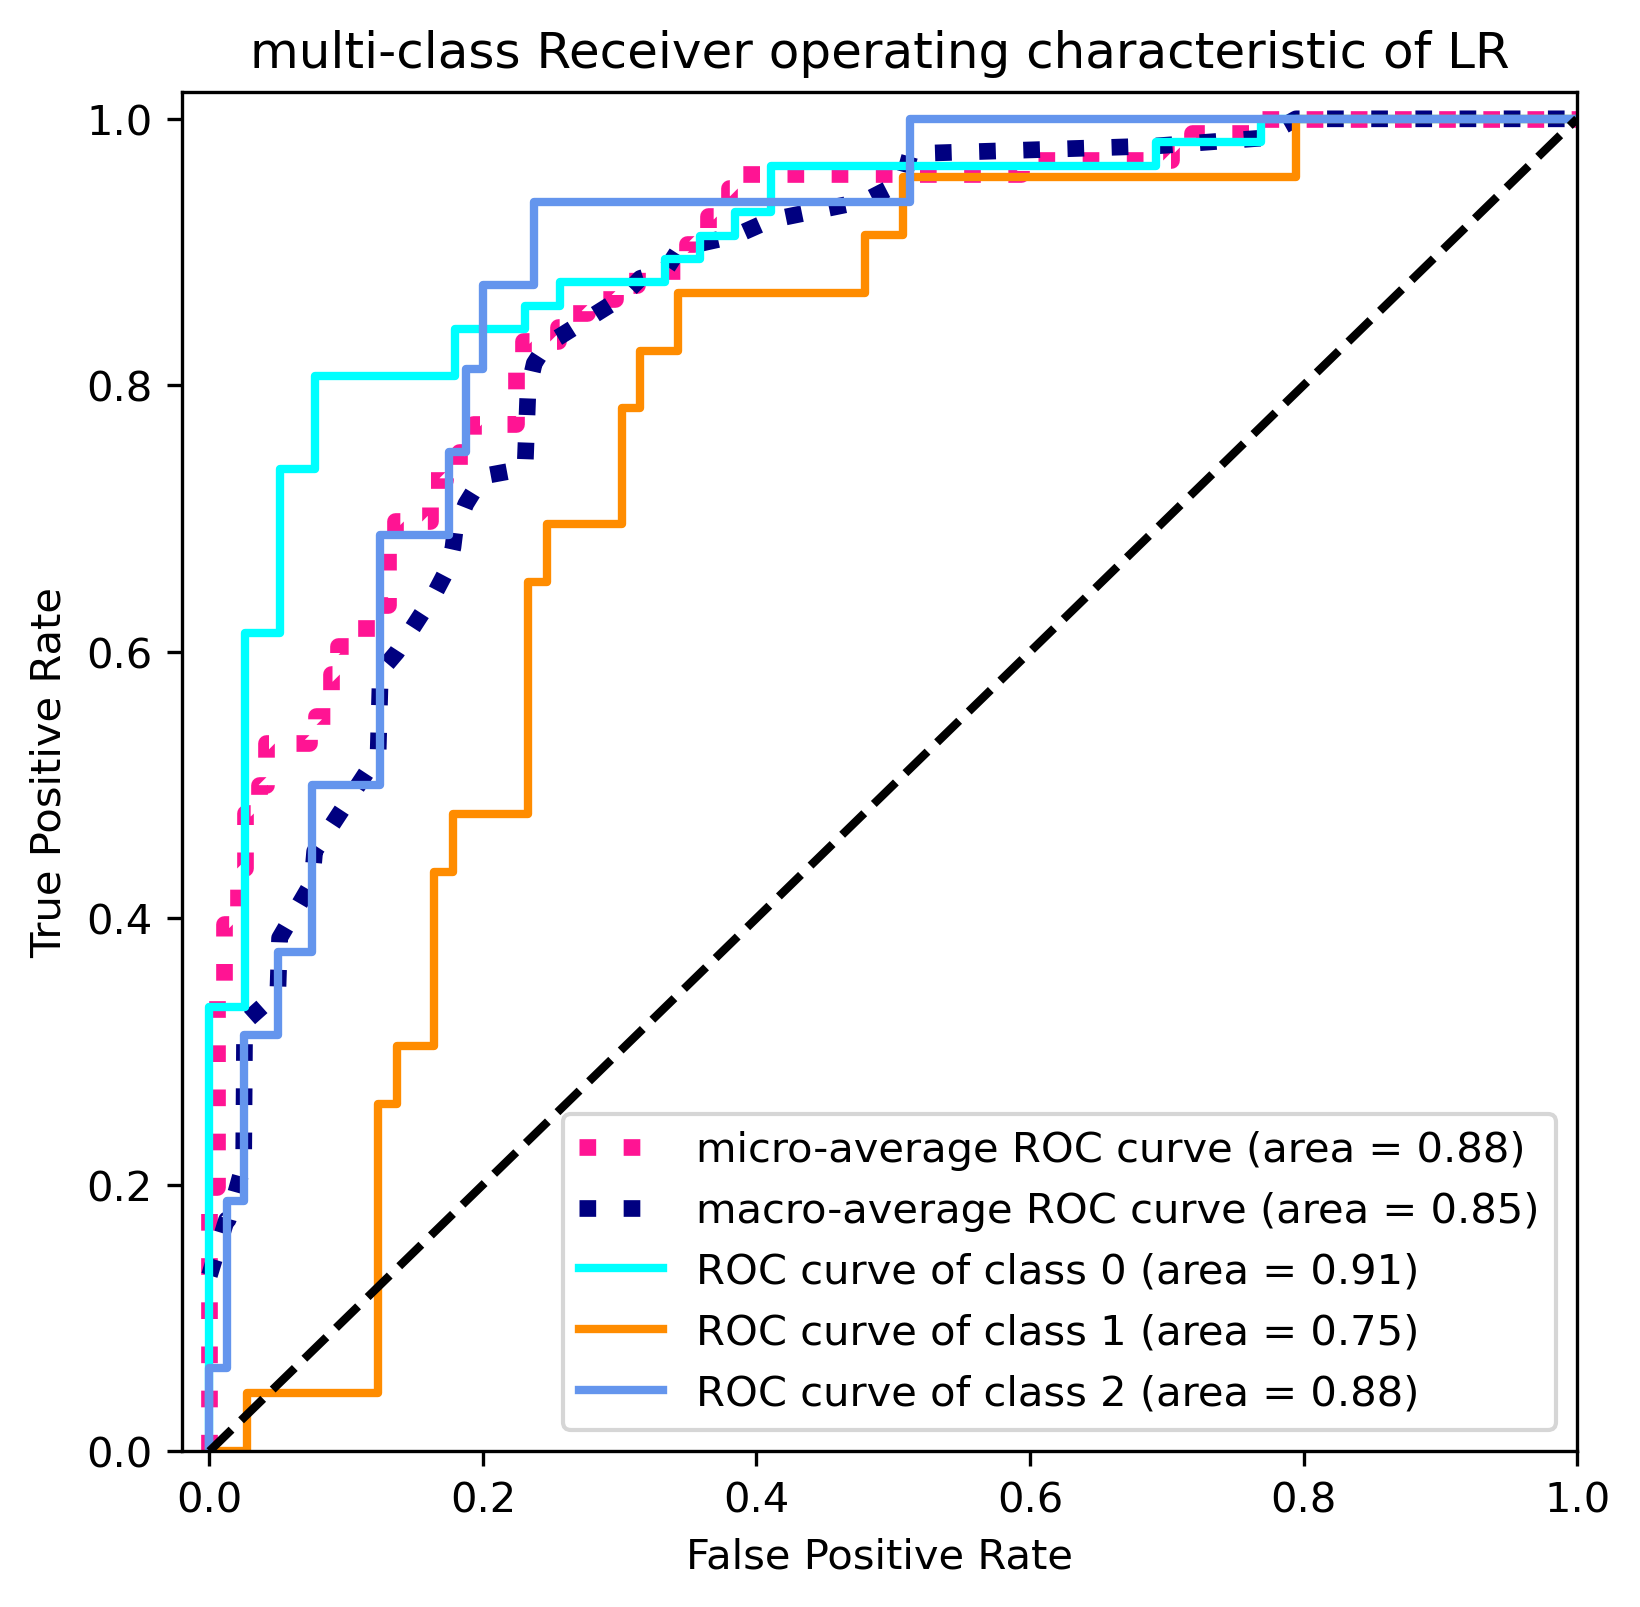

In [38]:
##测试集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy_bi[:, i], y_prob_test_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(testy_bi.ravel(), y_prob_test_lr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of LR')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_lr_test.tiff',dpi=300)

In [39]:
confusion_lr_mat1 = confusion_matrix(trainy, y_pred_train_lr)
print("confusion_mat_train.shape : {}".format(confusion_lr_mat1.shape))
print("confusion_mat_train:\n{}".format(confusion_lr_mat1))

##测试集
print()
confusion_lr_mat2 = confusion_matrix(testy, y_pred_test_lr)
print("confusion_mat_test.shape : {}".format(confusion_lr_mat2.shape))
print("confusion_mat_test:\n{}".format(confusion_lr_mat2))

confusion_mat_train.shape : (3, 3)
confusion_mat_train:
[[153  28   4]
 [ 37  67  17]
 [ 10  33  35]]

confusion_mat_test.shape : (3, 3)
confusion_mat_test:
[[48  9  0]
 [ 7 11  5]
 [ 1  9  6]]


[None, None, None, None, None, None]

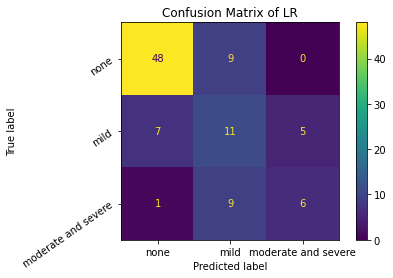

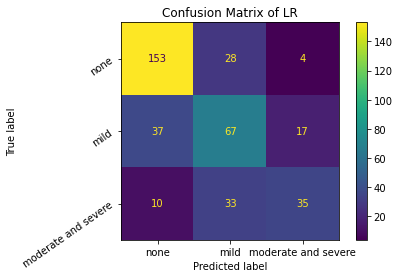

In [40]:
classes = ['none','mild','moderate and severe']
#fig = plt.figure(figsize=(15, 15))
disp2_lr = ConfusionMatrixDisplay(confusion_matrix=confusion_lr_mat2, display_labels=classes)
disp2_lr.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of LR')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp2_lr.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_lr_test.tiff',figsize=(10,10),dpi=300)


disp1_lr = ConfusionMatrixDisplay(confusion_matrix=confusion_lr_mat1, display_labels=classes)
disp1_lr.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of LR')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp1_lr.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_lr_train.tiff',dpi=300)

In [41]:
##训练集
accuracy_train_lr = metrics.accuracy_score(trainy,y_pred_train_lr)
print("accuracy_train_lr:{:.3}".format(accuracy_train_lr))
print()

##print("参数为None：输出每一类的指标")
none_p_train_lr = metrics.precision_score(trainy,y_pred_train_lr, average=None)
none_r_train_lr = metrics.recall_score(trainy,y_pred_train_lr, average=None)
none_f1_train_lr = metrics.f1_score(trainy,y_pred_train_lr, average=None)
np.set_printoptions(precision=3) 
print("none_p_train_lr:{}".format(none_p_train_lr))
print("none_r_train_lr:{}".format(none_r_train_lr))
print("none_f1_train_lr:{}".format(none_f1_train_lr))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_train_lr = metrics.precision_score(trainy,y_pred_train_lr, average='macro')
macro_r_train_lr = metrics.recall_score(trainy,y_pred_train_lr, average='macro')
macro_f1_train_lr = metrics.f1_score(trainy,y_pred_train_lr, average='macro')
print("macro_p_train_lr:{:.3}".format(macro_p_train_lr))
print("macro_r_train_lr:{:.3}".format(macro_r_train_lr))
print("macro_f1_train_lr:{:.3}".format(macro_f1_train_lr))
print()

##print("参数为micro")
micro_p_train_lr = metrics.precision_score(trainy,y_pred_train_lr, average='micro')
micro_r_train_lr = metrics.recall_score(trainy,y_pred_train_lr, average='micro')
micro_f1_train_lr = metrics.f1_score(trainy,y_pred_train_lr, average='micro')
print("micro_p_train_lr:{:.3}".format(micro_p_train_lr))
print("micro_r_train_lr:{:.3}".format(micro_r_train_lr))
print("micro_f1_train_lr:{:.3}".format(micro_f1_train_lr))
print()

##print("参数为weighted")
weighted_p_train_lr = metrics.precision_score(trainy,y_pred_train_lr, average='weighted')
weighted_r_train_lr = metrics.recall_score(trainy,y_pred_train_lr, average='weighted')
weighted_f1_train_lr = metrics.f1_score(trainy,y_pred_train_lr, average='weighted')
print("weighted_p_train_lr:{:.3}".format(weighted_p_train_lr))
print("weighted_r_train_lr:{:.3}".format(weighted_r_train_lr))
print("weighted_f1_train_lr:{:.3}".format(weighted_f1_train_lr))
print()

##马修斯相关系数
mcc_lr_train = matthews_corrcoef(trainy, y_pred_train_lr)
print("mcc_train_lr:{:.3}".format(mcc_lr_train))
print()

##kappa
matrix1_lr = np.array(confusion_lr_mat1)
matrix2_lr = np.array(confusion_lr_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_train_lr:{:.3}".format(kappa(matrix1_lr)))

accuracy_train_lr:0.664

none_p_train_lr:[0.765 0.523 0.625]
none_r_train_lr:[0.827 0.554 0.449]
none_f1_train_lr:[0.795 0.538 0.522]

macro_p_train_lr:0.638
macro_r_train_lr:0.61
macro_f1_train_lr:0.618

micro_p_train_lr:0.664
micro_r_train_lr:0.664
micro_f1_train_lr:0.664

weighted_p_train_lr:0.66
weighted_r_train_lr:0.664
weighted_f1_train_lr:0.659

mcc_train_lr:0.455

kappa_train_lr:0.453


In [42]:
##测试集
accuracy_test_lr = metrics.accuracy_score(testy,y_pred_test_lr)
print("accuracy_test_lr:{:.3}".format(accuracy_test_lr))
print()

##print("参数为None：输出每一类的指标")
none_p_test_lr = metrics.precision_score(testy,y_pred_test_lr, average=None)
none_r_test_lr = metrics.recall_score(testy,y_pred_test_lr, average=None)
none_f1_test_lr = metrics.f1_score(testy,y_pred_test_lr, average=None)
np.set_printoptions(precision=3) 
print("none_p_test_lr:{}".format(none_p_test_lr))
print("none_r_test_lr:{}".format(none_r_test_lr))
print("none_f1_test_lr:{}".format(none_f1_test_lr))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_test_lr = metrics.precision_score(testy,y_pred_test_lr, average='macro')
macro_r_test_lr = metrics.recall_score(testy,y_pred_test_lr, average='macro')
macro_f1_test_lr = metrics.f1_score(testy,y_pred_test_lr, average='macro')
print("macro_p_test_lr:{:.3}".format(macro_p_test_lr))
print("macro_r_test_lr:{:.3}".format(macro_r_test_lr))
print("macro_f1_test_lr:{:.3}".format(macro_f1_test_lr))
print()

##print("参数为micro")
micro_p_test_lr = metrics.precision_score(testy,y_pred_test_lr, average='micro')
micro_r_test_lr = metrics.recall_score(testy,y_pred_test_lr, average='micro')
micro_f1_test_lr = metrics.f1_score(testy,y_pred_test_lr, average='micro')
print("micro_p_test_lr:{:.3}".format(micro_p_test_lr))
print("micro_r_test_lr:{:.3}".format(micro_r_test_lr))
print("micro_f1_test_lr:{:.3}".format(micro_f1_test_lr))
print()

##print("参数为weighted")
weighted_p_test_lr = metrics.precision_score(testy,y_pred_test_lr, average='weighted')
weighted_r_test_lr = metrics.recall_score(testy,y_pred_test_lr, average='weighted')
weighted_f1_test_lr = metrics.f1_score(testy,y_pred_test_lr, average='weighted')
print("weighted_p_test_lr:{:.3}".format(weighted_p_test_lr))
print("weighted_r_test_lr:{:.3}".format(weighted_r_test_lr))
print("weighted_f1_test_lr:{:.3}".format(weighted_f1_test_lr))
print()

##马修斯相关系数
mcc_lr_test = matthews_corrcoef(testy, y_pred_test_lr)
print("mcc_test_lr:{:.3}".format(mcc_lr_test))
print()

##kappa
matrix1_lr = np.array(confusion_lr_mat1)
matrix2_lr = np.array(confusion_lr_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_test_lr:{:.3}".format(kappa(matrix2_lr)))

accuracy_test_lr:0.677

none_p_test_lr:[0.857 0.379 0.545]
none_r_test_lr:[0.842 0.478 0.375]
none_f1_test_lr:[0.85  0.423 0.444]

macro_p_test_lr:0.594
macro_r_test_lr:0.565
macro_f1_test_lr:0.572

micro_p_test_lr:0.677
micro_r_test_lr:0.677
micro_f1_test_lr:0.677

weighted_p_test_lr:0.691
weighted_r_test_lr:0.677
weighted_f1_test_lr:0.68

mcc_test_lr:0.428

kappa_test_lr:0.426


In [43]:
lr.multi_class

'auto'

SVM

In [25]:
svm = SVC(kernel='rbf',probability=True)
svm.fit(trainx_standard_1, trainy)

SVC(probability=True)

In [26]:
# 设置种类
n_classes = trainy_bi.shape[1]
y_prob_train_svm = svm.predict_proba(trainx_standard_1)
y_prob_test_svm = svm.predict_proba(testx_standard_1)
y_pred_train_svm = svm.predict(trainx_standard_1)
y_pred_test_svm = svm.predict(testx_standard_1)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


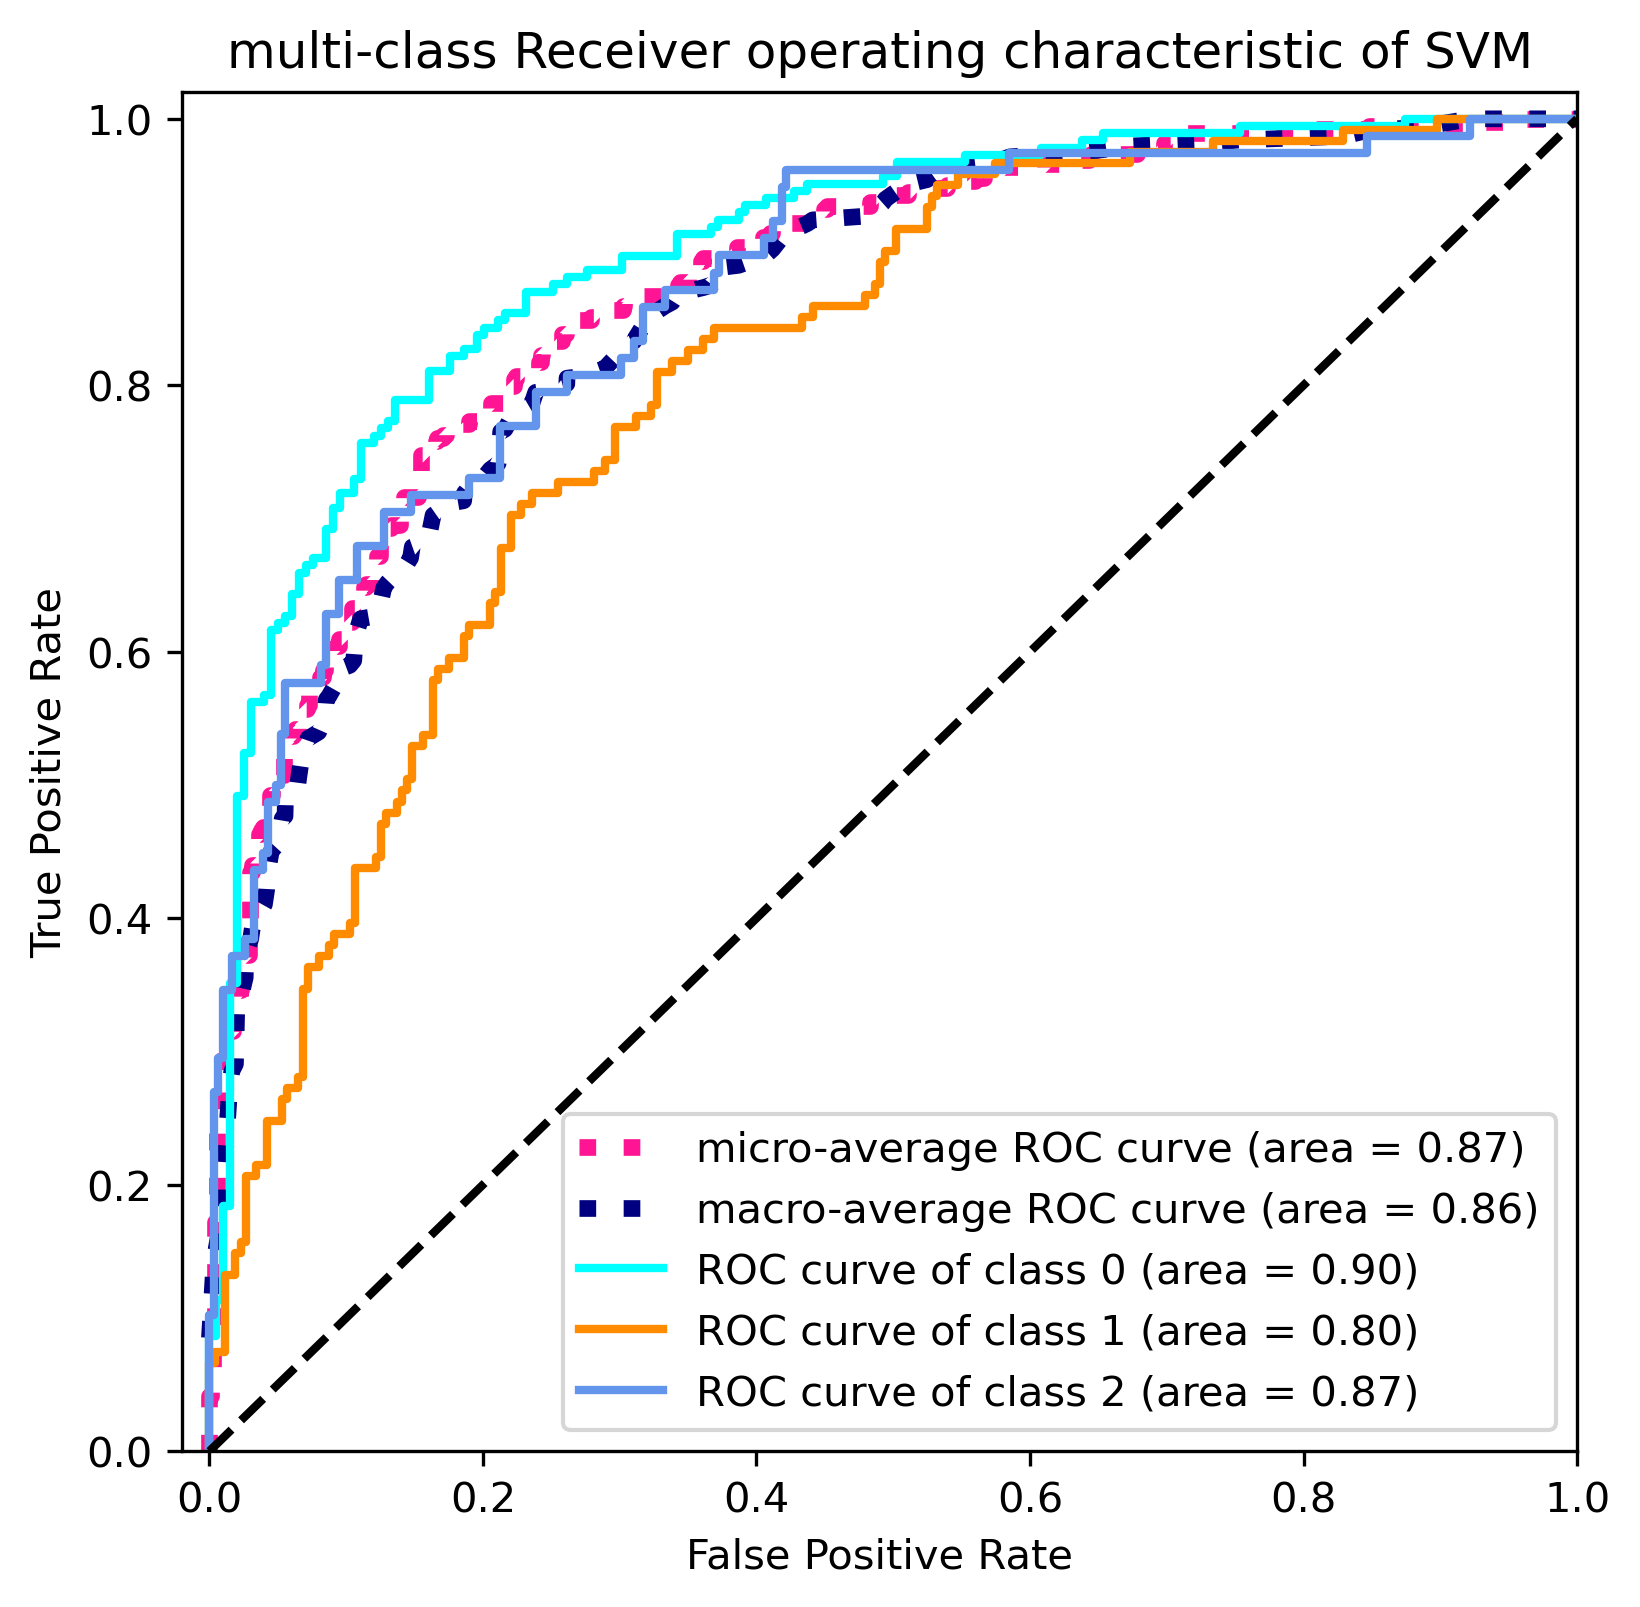

In [27]:
##训练集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(trainy_bi[:, i], y_prob_train_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(trainy_bi.ravel(), y_prob_train_svm.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of SVM')
plt.legend(loc="lower right")
plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_svm_train.tiff',dpi=300)

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


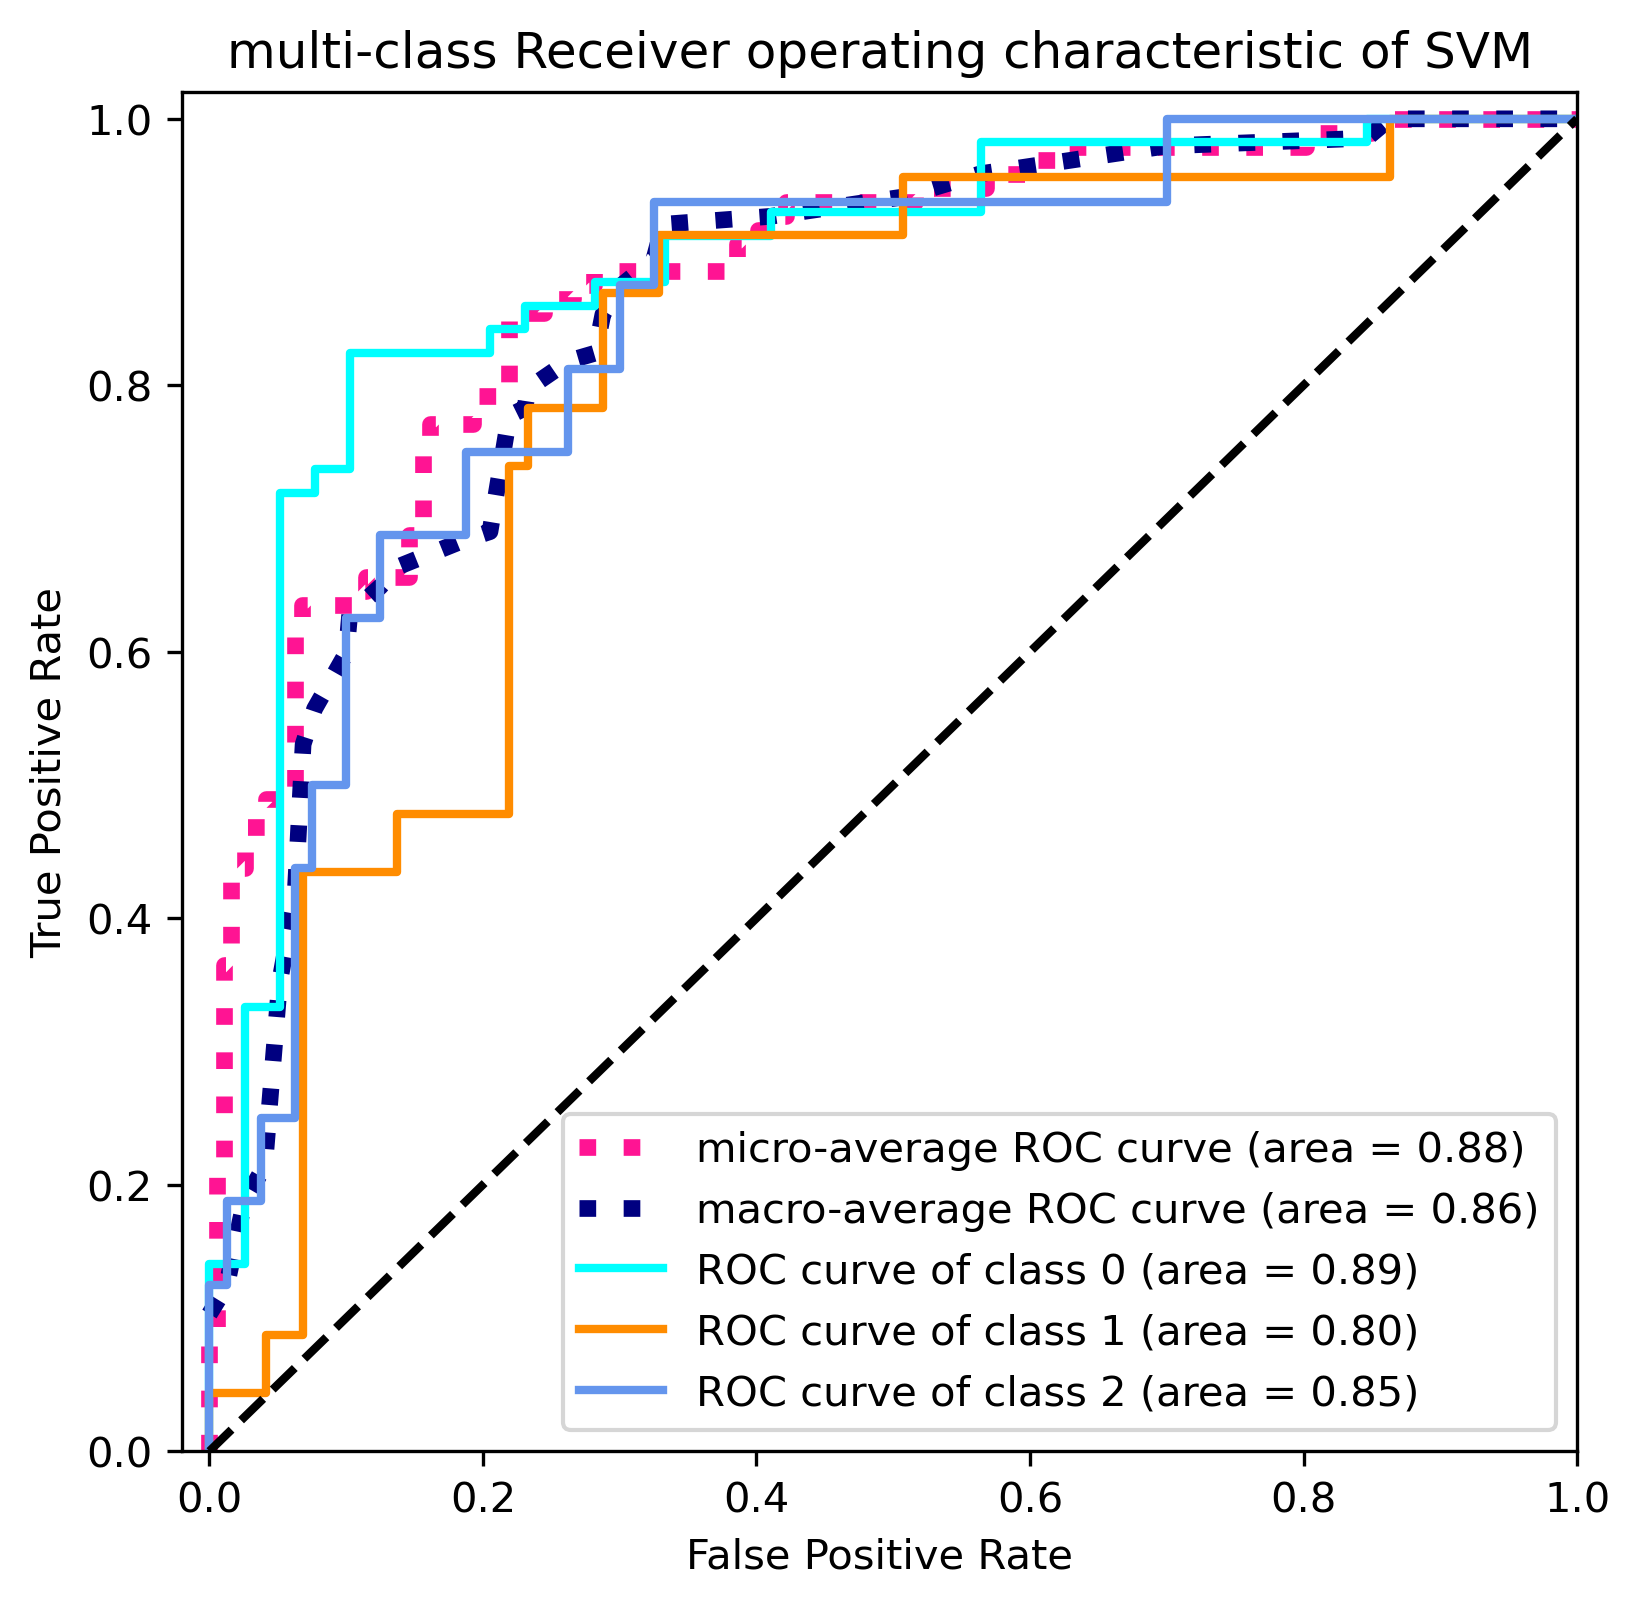

In [28]:
##测试集
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy_bi[:, i], y_prob_test_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 # Compute micro-average ROC curve and ROC area（micro）
fpr["micro"], tpr["micro"], _ = roc_curve(testy_bi.ravel(), y_prob_test_svm.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（macro）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure(figsize=(6,6),dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','#DB7093'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class Receiver operating characteristic of SVM')
plt.legend(loc="lower right")
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//roc_svm_test.tiff',dpi=300)

In [29]:
confusion_svm_mat1 = confusion_matrix(trainy, y_pred_train_svm)
print("confusion_mat_train.shape : {}".format(confusion_svm_mat1.shape))
print("confusion_mat_train:\n{}".format(confusion_svm_mat1))

##测试集
print()
confusion_svm_mat2 = confusion_matrix(testy, y_pred_test_svm)
print("confusion_mat_test.shape : {}".format(confusion_svm_mat2.shape))
print("confusion_mat_test:\n{}".format(confusion_svm_mat2))

confusion_mat_train.shape : (3, 3)
confusion_mat_train:
[[153  32   0]
 [ 28  76  17]
 [ 10  26  42]]

confusion_mat_test.shape : (3, 3)
confusion_mat_test:
[[48  9  0]
 [ 2 16  5]
 [ 3  7  6]]


[None, None, None, None, None, None]

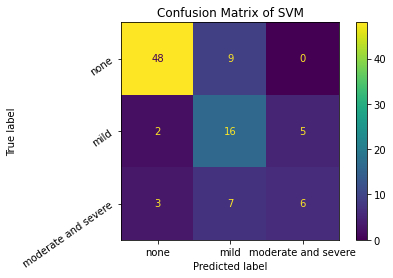

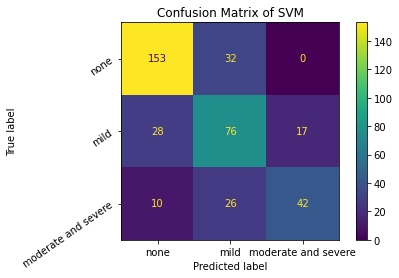

In [30]:
classes = ['none','mild','moderate and severe']
#fig = plt.figure(figsize=(15, 15))
disp2_svm = ConfusionMatrixDisplay(confusion_matrix=confusion_svm_mat2, display_labels=classes)
disp2_svm.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of SVM')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp2_svm.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_svm_test.tiff',figsize=(10,10),dpi=300)


disp1_svm = ConfusionMatrixDisplay(confusion_matrix=confusion_svm_mat1, display_labels=classes)
disp1_svm.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="viridis",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d" # 显示的数值格式

)

plt.title('Confusion Matrix of SVM')
# 设置横轴和纵轴的标题倾斜，并设置倾斜角度为45度
#plt.setp(disp1.ax_.xaxis.get_majorticklabels(), rotation=20)
plt.setp(disp1_svm.ax_.yaxis.get_majorticklabels(), rotation=35)
#plt.savefig('D://Jupyter_project//结缔组织抑郁//中重度合并后//cm_svm_train.tiff',dpi=300)

In [31]:
##训练集
accuracy_train_svm = metrics.accuracy_score(trainy,y_pred_train_svm)
print("accuracy_train_svm:{:.3}".format(accuracy_train_svm))
print()

##print("参数为None：输出每一类的指标")
none_p_train_svm = metrics.precision_score(trainy,y_pred_train_svm, average=None)
none_r_train_svm = metrics.recall_score(trainy,y_pred_train_svm, average=None)
none_f1_train_svm = metrics.f1_score(trainy,y_pred_train_svm, average=None)
np.set_printoptions(precision=3) 
print("none_p_train_svm:{}".format(none_p_train_svm))
print("none_r_train_svm:{}".format(none_r_train_svm))
print("none_f1_train_svm:{}".format(none_f1_train_svm))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_train_svm = metrics.precision_score(trainy,y_pred_train_svm, average='macro')
macro_r_train_svm = metrics.recall_score(trainy,y_pred_train_svm, average='macro')
macro_f1_train_svm = metrics.f1_score(trainy,y_pred_train_svm, average='macro')
print("macro_p_train_svm:{:.3}".format(macro_p_train_svm))
print("macro_r_train_svm:{:.3}".format(macro_r_train_svm))
print("macro_f1_train_svm:{:.3}".format(macro_f1_train_svm))
print()

##print("参数为micro")
micro_p_train_svm = metrics.precision_score(trainy,y_pred_train_svm, average='micro')
micro_r_train_svm = metrics.recall_score(trainy,y_pred_train_svm, average='micro')
micro_f1_train_svm = metrics.f1_score(trainy,y_pred_train_svm, average='micro')
print("micro_p_train_svm:{:.3}".format(micro_p_train_svm))
print("micro_r_train_svm:{:.3}".format(micro_r_train_svm))
print("micro_f1_train_svm:{:.3}".format(micro_f1_train_svm))
print()

##print("参数为weighted")
weighted_p_train_svm = metrics.precision_score(trainy,y_pred_train_svm, average='weighted')
weighted_r_train_svm = metrics.recall_score(trainy,y_pred_train_svm, average='weighted')
weighted_f1_train_svm = metrics.f1_score(trainy,y_pred_train_svm, average='weighted')
print("weighted_p_train_svm:{:.3}".format(weighted_p_train_svm))
print("weighted_r_train_svm:{:.3}".format(weighted_r_train_svm))
print("weighted_f1_train_svm:{:.3}".format(weighted_f1_train_svm))
print()

##马修斯相关系数
mcc_svm_train = matthews_corrcoef(trainy, y_pred_train_svm)
print("mcc_train_svm:{:.3}".format(mcc_svm_train))
print()

##kappa
matrix1_svm = np.array(confusion_svm_mat1)
matrix2_svm = np.array(confusion_svm_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_train_svm:{:.3}".format(kappa(matrix1_svm)))

accuracy_train_svm:0.706

none_p_train_svm:[0.801 0.567 0.712]
none_r_train_svm:[0.827 0.628 0.538]
none_f1_train_svm:[0.814 0.596 0.613]

macro_p_train_svm:0.693
macro_r_train_svm:0.665
macro_f1_train_svm:0.674

micro_p_train_svm:0.706
micro_r_train_svm:0.706
micro_f1_train_svm:0.706

weighted_p_train_svm:0.709
weighted_r_train_svm:0.706
weighted_f1_train_svm:0.704

mcc_train_svm:0.526

kappa_train_svm:0.525


In [32]:
##测试集
accuracy_test_svm = metrics.accuracy_score(testy,y_pred_test_svm)
print("accuracy_test_svm:{:.3}".format(accuracy_test_svm))
print()

##print("参数为None：输出每一类的指标")
none_p_test_svm = metrics.precision_score(testy,y_pred_test_svm, average=None)
none_r_test_svm = metrics.recall_score(testy,y_pred_test_svm, average=None)
none_f1_test_svm = metrics.f1_score(testy,y_pred_test_svm, average=None)
np.set_printoptions(precision=3) 
print("none_p_test_svm:{}".format(none_p_test_svm))
print("none_r_test_svm:{}".format(none_r_test_svm))
print("none_f1_test_svm:{}".format(none_f1_test_svm))
print()

##print("参数为macro：不适合类别不平衡的情况")
macro_p_test_svm = metrics.precision_score(testy,y_pred_test_svm, average='macro')
macro_r_test_svm = metrics.recall_score(testy,y_pred_test_svm, average='macro')
macro_f1_test_svm = metrics.f1_score(testy,y_pred_test_svm, average='macro')
print("macro_p_test_svm:{:.3}".format(macro_p_test_svm))
print("macro_r_test_svm:{:.3}".format(macro_r_test_svm))
print("macro_f1_test_svm:{:.3}".format(macro_f1_test_svm))
print()

##print("参数为micro")
micro_p_test_svm = metrics.precision_score(testy,y_pred_test_svm, average='micro')
micro_r_test_svm = metrics.recall_score(testy,y_pred_test_svm, average='micro')
micro_f1_test_svm = metrics.f1_score(testy,y_pred_test_svm, average='micro')
print("micro_p_test_svm:{:.3}".format(micro_p_test_svm))
print("micro_r_test_svm:{:.3}".format(micro_r_test_svm))
print("micro_f1_test_svm:{:.3}".format(micro_f1_test_svm))
print()

##print("参数为weighted")
weighted_p_test_svm = metrics.precision_score(testy,y_pred_test_svm, average='weighted')
weighted_r_test_svm = metrics.recall_score(testy,y_pred_test_svm, average='weighted')
weighted_f1_test_svm = metrics.f1_score(testy,y_pred_test_svm, average='weighted')
print("weighted_p_test_svm:{:.3}".format(weighted_p_test_svm))
print("weighted_r_test_svm:{:.3}".format(weighted_r_test_svm))
print("weighted_f1_test_svm:{:.3}".format(weighted_f1_test_svm))
print()

##马修斯相关系数
mcc_svm_test = matthews_corrcoef(testy, y_pred_test_svm)
print("mcc_test_svm:{:.3}".format(mcc_svm_test))
print()

##kappa
matrix1_svm = np.array(confusion_svm_mat1)
matrix2_svm = np.array(confusion_svm_mat2)
#matrix3_ann = np.array(confusion_ann_mat3)
print("kappa_train_svm:{:.3}".format(kappa(matrix2_svm)))

accuracy_test_svm:0.729

none_p_test_svm:[0.906 0.5   0.545]
none_r_test_svm:[0.842 0.696 0.375]
none_f1_test_svm:[0.873 0.582 0.444]

macro_p_test_svm:0.65
macro_r_test_svm:0.638
macro_f1_test_svm:0.633

micro_p_test_svm:0.729
micro_r_test_svm:0.729
micro_f1_test_svm:0.729

weighted_p_test_svm:0.748
weighted_r_test_svm:0.729
weighted_f1_test_svm:0.732

mcc_test_svm:0.534

kappa_train_svm:0.528


In [33]:
svm.decision_function_shape

'ovr'

SyntaxError: invalid syntax (4246556919.py, line 13)